# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [1]:
%load_ext autoreload
%autoreload 2

NOTE: Need to add anchor jump links to each heading

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup 
<br> 1.4. Project Changes from Initial Proposal
<br> 1.5. Project Presentation Video

2. Model building approach
<br> 2.1. SimplePose (Baseline model) 
<br> 2.2. SimplePoseGNN
<br> 2.3. SimplePoseGAT
<br> 2.4. SimplePoseTAG

3. Human 3.6M Dataset
<br> 3.1. Summary of the dataset
<br> 3.2. Preparing the dataset
<br> 3.3. Visualizing poses
<br> 3.4. Training baseline model (SimplePose)
<br> 3.5. Training Graph Convolutional model (SimplePoseGNN)
<br> 3.6. Training Graph Transformer model (SimplePoseGAT)
<br> 3.7. Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG)

4. Custom Dataset
<br> 4.1. Summary of the dataset
<br> 4.2. Preparing the dataset
<br> 4.3. Visualizing poses
<br> 4.4. Training baseline model (SimplePose)
<br> 4.5. Training Graph Convolutional model (SimplePoseGNN)
<br> 4.6. Training Graph Transformer model (SimplePoseGAT)
<br> 4.7. Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG)

5. Evaluation
<br> 5.1. Human 3.6M dataset
<br> 5.2. Custom Dataset

6. Lessons Learnt
   
7. Overall Performance Analysis, Limitations & Future Work
   
8. Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1. Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is essential for applications like motion capture and activity recognition. Traditional methods, such as direct regression or lifting techniques, often fail to capture the intricate spatial relationships between body joints. By modeling 2D pose keypoints as graphs, we can utilize the inherent connectivity between joints to enhance 3D pose estimation. Furthermore, recognizing and classifying human activities from these poses is vital in areas like surveillance and healthcare. This project aims to investigate how Graph Neural Networks (GNNs) can improve both 3D pose estimation and activity recognition.

<h3><u>1.2. Project Description</h3></u>

In this project, our goal is to use 2D keypoints to predict 3D human poses along with its activity label via a multitask objective using Graph Neural Networks (GNN).

* We will build a Neural Network model as a baseline model and compare it against Graph Neural Network models. For more information, please refer to Section 2.

* Additionally, we also will build our own custom dataset to evaluate the performance of our models. For more information, please refer to Section 4.

<h3><u>1.3. Project Setup</u></h3>

To run this project, please run the cell below and restart your session.


In [ ]:
# NOTE: you will have to restart the session multiple times!

# Basic Libraries
%pip install numpy==1.24
%pip install matplotlib==3.7
%pip install scipy==1.10.1
%pip install networkx==3.1
%pip install seaborn==0.13

# Graph Libraries
%pip install pymetis==2023.1
%pip install python-louvain==0.16

# Molecule Libraries
%pip install rdkit==2023.09.6  # Adjust the version as necessary

# Deep Learning Libraries
%pip install torch==2.1.2
%pip install torchvision==0.16

# Additional Pip-specific Libraries
%pip install plotly==5.22.0
%pip install scikit-learn==1.3.2
%pip install umap-learn==0.5.6

# DGL (Deep Graph Library)
%pip install  dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html

# TorchViz
%pip install torchviz

# GDown
%pip install gdown

# H5py
%pip install h5py




<h3><u>1.4. Project Changes from Initial Proposal</u></h3>

In our initial [proposal](./resources/CS5248_Graph_Machine_Learning_Project_Proposal%20_Group_16.pdf), we wanted to reimplement SemGCN for our project. Due to the difficulty of translating PyTorch code to DGL, we replaced SemGCN with SimplePoseTAG. 

<h3><u>1.5. Project Presentation Video</u></h3>

Our project presentation has been uploaded to youtube and can be found at <a href="https://youtu.be/O3Qb1UfjszM">this link</a>. 

<h2><u>2. Model Building Approach</u></h2>

Previous works have attempted to do pose estimation and activity recognition via normal Neural Network methods such as Convolutional Neural Networks such as [PoseCNN: A Convolutional Neural Network for 6D Object Pose Estimation in Cluttered Scenes by Xiang. et al](https://arxiv.org/abs/1711.00199) and [Skeleton-based Human Action Recognition via
Convolutional Neural Networks (CNN) by Ali. et al](https://arxiv.org/pdf/2301.13360).



<h3><u>2.1 SimplePose (Baseline model)</u></h3>

To study the effectiveness of Graph Neural Networks in 3D Pose Estimation and Activity Recognition, we built our own basic Neural Network model which we will call it as SimplePose.

SimplePose is a simple Neural Network model that uses the same model architecture as [A simple yet effective baseline for 3d human pose estimation by Martinez. et al](https://arxiv.org/abs/1705.03098) but with a few tweaks compared against the original architecture.

These are the tweaks that we have done for SimplePose:-

1. We increased the dropout rate from 0.5 to 0.6 to ensure stable training and to prevent overfitting.
2. Instead of having 2 blocks as shown in Figure 1, we have 6 blocks because we found out it having bigger models enabled the multitask learning to perform well for SimplePose.
3. After the last block, we add a small Neural Network for 3D Pose Estimation and another small Neural Network for Activity Recognition. Both of their inputs is the last block final output.

You can see the SimplePose's implementation at [models/simple_pose.py](./models/simple_pose.py)

The figure below illustrates the SimplePose Architecture:-

<img title="SimplePose" alt="SimplePose" src="./visualizations/notebook_images/SimplePose.drawio.png">


Below shows the number of trainable parameters for SimplePose:-

In [2]:
from models.simple_pose import SimplePose
from utils.pytorch_utils import count_parameters
model = SimplePose(total_joints=13, total_actions=5)
parameters = count_parameters(model)
print(f"SimplePose Trainable Parameters: {parameters}")

SimplePose Trainable Parameters: 13973036


<h3><u>2.2 SimplePoseGNN</u></h3>

We built 3 Graph Neural Networks to compare against SimplePose. Our first model is a Graph Convolutional Neural Network which we will call it as SimplePoseGNN.

SimplePoseGNN is a Graph Convolutional Neural Network model that was proposed by [Kipf. et al](https://arxiv.org/pdf/1609.02907v4). We decided to implement this model because it is the baseline model for Graph Neural Networks.

For our Graph Convolutional Layers for SimplePoseGNN, we used [GraphConv from DGL](https://docs.dgl.ai/en/1.1.x/generated/dgl.nn.pytorch.conv.GraphConv.html) in its default settings to build our own GraphConvModule.

A GraphConvModule consists of these layers in sequence.:-
1. GraphConv
2. BatchNorm1D
3. ReLU
4. GraphConv
5. BatchNorm1D
6. Dropout 
7. ReLU
8. Linear Layer
   
There is also a residual connection that connects from the input of the first GraphConv with the output from Linear Layer.

SimplePoseGNN has 6 GraphConvModule to ensure good performance.

Not only that, these are the additional modifications we have done for SimplePoseGNN:-

1. We compute the Laplacian Positional Encoding of our graph inputs using [dgl.transforms.LapPE](https://docs.dgl.ai/en/1.1.x/generated/dgl.transforms.LapPE.html) with k = 5.
2. We embed our Node Features, Laplacian Positional Encodings and Edge features into their own nn.Linear layers and concatenate the values before giving it to the first GraphConvModule.
3. We add a small Neural Network for 3D Pose Estimation and Activity Recognition after the last GraphConvModule. Their inputs are the output of the last GraphConvModule.

You can see the SimplePoseGNN's implementation at [models/simple_pose_gnn.py](./models/simple_pose_gnn.py)

Here is SimplePoseGNN's architecture as described:-

<img title="SimplePoseGNN" alt="SimplePoseGNN" src="./visualizations/notebook_images/SimplePoseGNN.drawio.png">

Below shows the number of trainable parameters for SimplePoseGNN:-

In [3]:
from models.simple_pose_gnn import SimplePoseGNN
from utils.pytorch_utils import count_parameters
model = SimplePoseGNN(hidden_size=80, num_classes=5)
parameters = count_parameters(model)
print(f"SimplePoseGNN Trainable Parameters: {parameters}")

SimplePoseGNN Trainable Parameters: 251848


<h3><u>2.3 SimplePoseGAT</u></h3>

Our 2nd Graph Neural Network implementation is the Graph Transformer Neural Network which we denote it as SimplePoseGAT.

SimplePoseGAT is a Graph Transformer Neural Network model that is proposed by [Dwivedi et al](https://arxiv.org/pdf/2012.09699v2). We decided to implement this model because we want to investigate if having attention scores can help improve the tasks' performance compared against all the other models.

For this implementation, we followed the Graph Transformer's implementation as described in [DGL's Graph Transformers Tutorial](https://docs.dgl.ai/en/1.1.x/notebooks/sparse/graph_transformer.html) but with our own tweaks.

These are the tweaks that we have done for SimplePoseGAT:-

1. We compute the Laplacian Positional Encoding of our graph inputs using [dgl.transforms.LapPE](https://docs.dgl.ai/en/1.1.x/generated/dgl.transforms.LapPE.html) with k = 20.
2. We embed our Node Features, Laplacian Positional Encodings and Edge features into their own nn.Linear layers and concatenate the values before giving it to the MultiHeadAttention Layer.
3. We reduced the Graph Transformer Layers to 2 due to GPU memory limitations.
4. We add a linear layer after the Graph Transformer to perform 3D Pose Estimations.
5. We add a SumPooling layer followed by a small neural network model to perform Activity Recognition.

You can see the SimplePoseGAT's implementation at [models/simple_pose_gat.py](./models/simple_pose_gat.py)

The figure below illustrates the SimplePoseGAT Architecture:-

<img title="SimplePoseGAT" alt="SimplePoseGAT" src="./visualizations/notebook_images/SimplePoseGAT.drawio.png">


Below shows the number of trainable parameters for SimplePoseGAT:-

In [4]:
from models.simple_pose_gat import SimplePoseGAT
from utils.pytorch_utils import count_parameters
model = SimplePoseGAT(in_size=2, out_size=3, num_classes=5)
parameters = count_parameters(model)
print(f"SimplePoseGAT Trainable Parameters: {parameters}")

SimplePoseGAT Trainable Parameters: 110888


<h3><u>2.4 SimplePoseTAG</u></h3>

For our final Graph Neural Network model, we built a Topology Adaptive Graph Convolutional Neural Network that was proposed by [Du. et al](https://arxiv.org/pdf/1710.10370).

We will call this model as SimplePoseTAG. We decided to implement SimplePoseTAG because we want to see if allowing the model to interpret the topology of a graph can improve the tasks' performance as compared with other models

For this implementation. we followed the same approach as SimplePoseGNN as stated in Section 2.2 with a few differences.

1. We replaced the GraphConv layers with [TAGConv from DGL.](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.TAGConv.html). We also renamed this from GraphConvModule to TAGConvModule.

You can see the SimplePoseTAG's implementation at [models/simple_pose_tag.py](./models/simple_pose_tag.py)

The figure below illustrates the SimplePoseTAG Architecture:-

<img title="SimplePoseTAG" alt="SimplePoseTAG" src="./visualizations/notebook_images/SimplePoseTAG.drawio.png">


Below shows the number of trainable parameters for SimplePoseTAG:-

In [5]:
from models.simple_pose_tag import SimplePoseTAG
from utils.pytorch_utils import count_parameters
model = SimplePoseTAG(hidden_size=80, num_classes=5)
parameters = count_parameters(model)
print(f"SimplePoseTAG Trainable Parameters: {parameters}")

SimplePoseTAG Trainable Parameters: 1019848


<h3><u>2.5 DGL Graph Dataloader</u></h3>

Below shows a sample of how the graph will look like when we translate the data to a graph.

The Nodes contains these information:-
1. Node Features: 2D Coordinates (x, y)
2. Node Labels: 3D Coordinates (x, y, z)

The Edges are bidirectional and contains these information:
1. Edge Features: A tensor containing this shape, [x1, y1, x2, y2]

The Graph contains these information:
1. Graph Label: An activity label.

For more information, please refer to [dataloader/h36m_graph_loader_with_edge_feats](./dataloader/h36m_graph_loader_with_edge_feats.py)

Graph(num_nodes=13, num_edges=28,
      ndata_schemes={'feat_2d': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)})


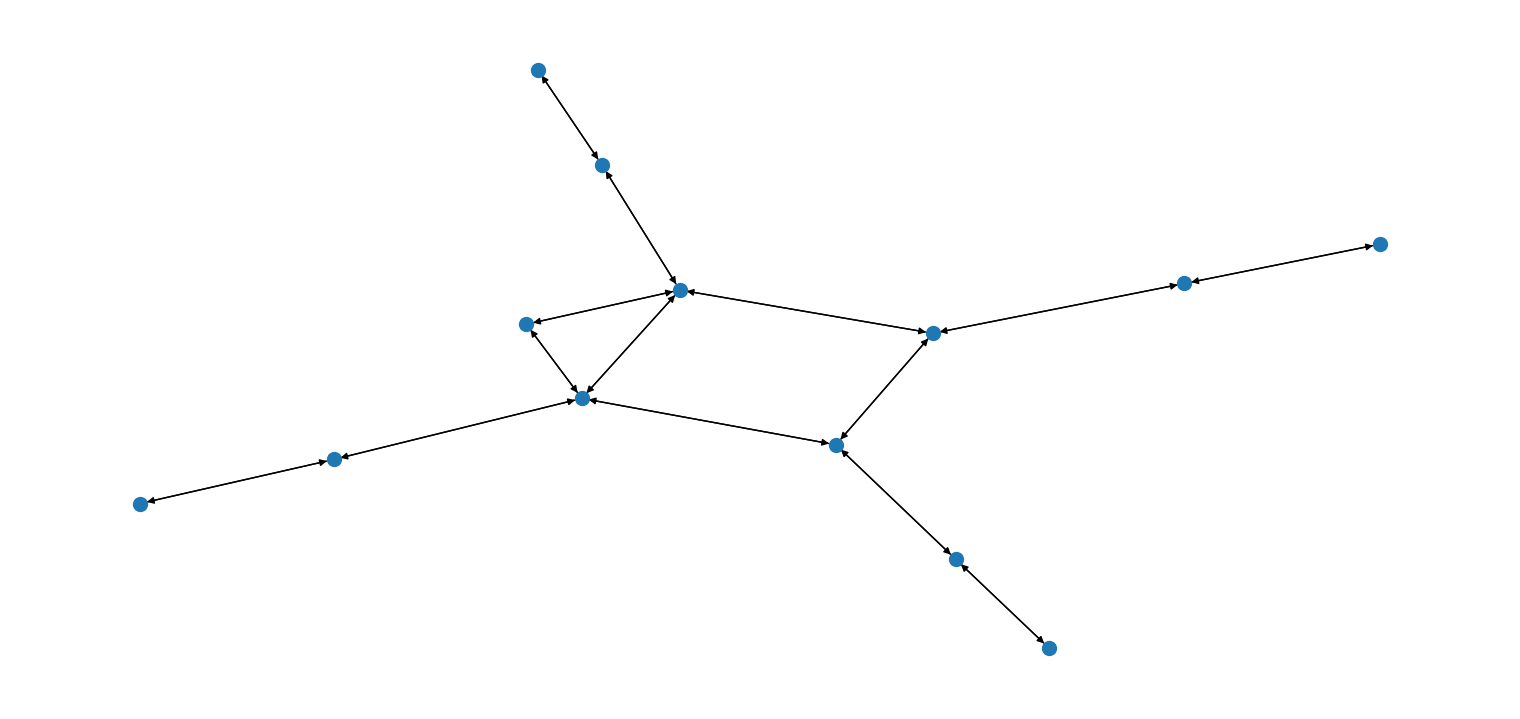

In [ ]:
from dataloader.h36m_graph_loader_with_edge_feats import Human36MGraphEdgeDataset
import networkx as nx
import dgl
import os

item = {
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
}

training_data = Human36MGraphEdgeDataset(item['training_2d_data_path'], item['training_3d_data_path'], item['training_label_path'])
g = training_data[0][0]
print(g)
options = {
    'node_size': 100,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)


<h2><u>3. Human 3.6M Dataset</u></h2>

<h3><u>3.1. Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a comprehensive dataset comprising 3.6 million 3D human poses, captured from 11 professional actors performing 17 everyday activities (e.g., talking, smoking, discussing).

This dataset utilizes a 3D motion capture system with 10 cameras to track reflective markers placed on the body, enabling automatic labeling of joint positions.

Participants were provided with detailed task instructions and visual examples of the actions to perform, but they were also allowed some freedom to move naturally during execution.

As a result, the Human 3.6M dataset serves as a valuable resource for 3D human pose estimation, action recognition, and other computer vision research tasks.

<h3><u>3.2. Dataset preparation </u></h3>

Downloading the Human 3.6M dataset directly from the official website requires a login. To simplify access, we will use a preprocessed version of the dataset, which is available on Google Drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).

The preprocessing was originally performed by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) and is sourced from their repository.

The following cells outline the steps to download this preprocessed dataset and create train-test files after applying necessary transformations.

From Section 3 (Models) onward, we will use the preprocessed train-test files directly. Therefore, executing the cells in this section is optional.

#### Downloading the zip from google drive

In [6]:
# Download the zip from google drive
import gdown
import os

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s
From (redirected): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s&confirm=t&uuid=081e5f0a-4fba-4a1f-a350-d7fd232a9a8d
To: d:\nus\Poseidon\datasets\h36m\Original\h36m.zip
100%|██████████| 260M/260M [00:09<00:00, 26.3MB/s] 

Downloaded ZIP file and saved to d:\nus\Poseidon\datasets\h36m\Original\h36m.zip


#### Extracting the contents into the same folder

In [7]:
# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")



Extracting files to d:\nus\Poseidon\datasets\h36m\Original..
Finished extracting files to d:\nus\Poseidon\datasets\h36m\Original


#### Saving the 3d positions into a compressed np file

In [8]:
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output


Processing subjects..: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Saving compressed 3d positions into d:\nus\Poseidon\datasets\h36m\Original\data_3d_h36m
Finished saving 3d positions into d:\nus\Poseidon\datasets\h36m\Original\data_3d_h36m


#### Compute the ground truth 2d poses.

The motion capture system records 3D poses using 10 cameras in the world coordinate frame. By applying the intrinsic and extrinsic matrices of each camera, these 3D poses are projected into 2D poses as they would appear in the respective camera's frame. The coordinates are then normalized so that the x, y, and z values range between -1 and 1.

In [9]:
from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

Computing ground-truth 2D poses...
Saving compressed 2d positions into d:\nus\Poseidon\datasets\h36m\Original\data_2d_h36m_gt
Done saving compressed 2d positions into d:\nus\Poseidon\datasets\h36m\Original\data_2d_h36m_gt


#### Cleanup the extracted files and the downloaded zip

In [10]:
from shutil import rmtree

rmtree(os.path.join(folder_path, 'h36m'))
os.remove(os.path.join(folder_path, 'h36m.zip'))

#### Creating and saving train and test files from the saved npz files

In [11]:
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
import os

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)


#### Normalizing the 2D poses to [-1, 1] while preserving aspect ratio and 3D poses to camera's frame

In [12]:
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

Reading 3d npz file
Reading 2d npz file
Done


#### Select subset of distinct actions to train and test models

In [13]:
keep_actions = [
    'Greeting',
    'Photo',
    'Sitting',
    'SittingDown',
    'Walking'
]

#### Save the 2D poses, 3D poses, and actions in numpy files

In [14]:
print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path, keep_actions)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path, keep_actions)
print("Done")

Creating train datasets and saving into file
Saved pose actions in file d:\nus\Poseidon\datasets\h36m\Processed\train_actions.npy
Saved 3d poses in file d:\nus\Poseidon\datasets\h36m\Processed\train_3d_poses.npy
Saved 2d poses in file d:\nus\Poseidon\datasets\h36m\Processed\train_2d_poses.npy
Creating test datasets and saving into file
Saved pose actions in file d:\nus\Poseidon\datasets\h36m\Processed\test_actions.npy
Saved 3d poses in file d:\nus\Poseidon\datasets\h36m\Processed\test_3d_poses.npy
Saved 2d poses in file d:\nus\Poseidon\datasets\h36m\Processed\test_2d_poses.npy
Done


<h3><u>3.3 Visualizing poses </u></h3>

Since the train and test files have already been saved, we will use these files for the remainder of the notebook.

These files are also available in this [Google Drive Link](https://drive.google.com/drive/folders/1d38hWSM8clZlI11nqljxBECog1KY-iTd?usp=sharing), which can be placed in the local path to skip the execution of earlier cells.

The visualizations below indicate that, after the processing steps outlined above, human poses are represented as skeletons consisting of 13 joints.

Let's visualise the poses for the 5 actions in the h3.6m dataset

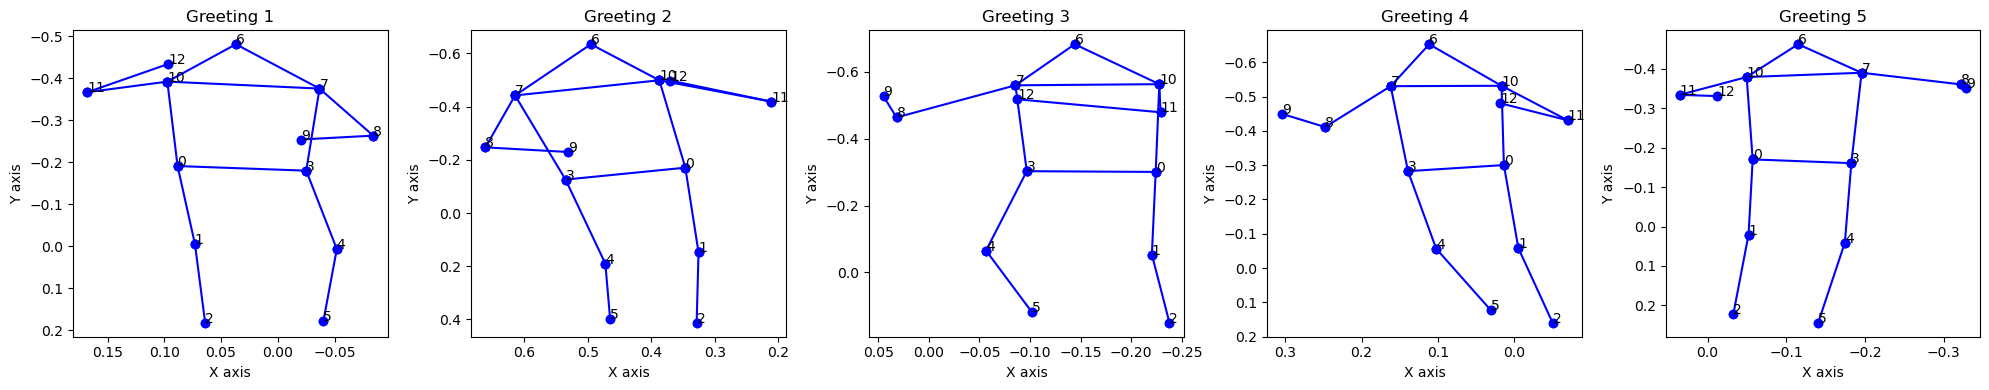

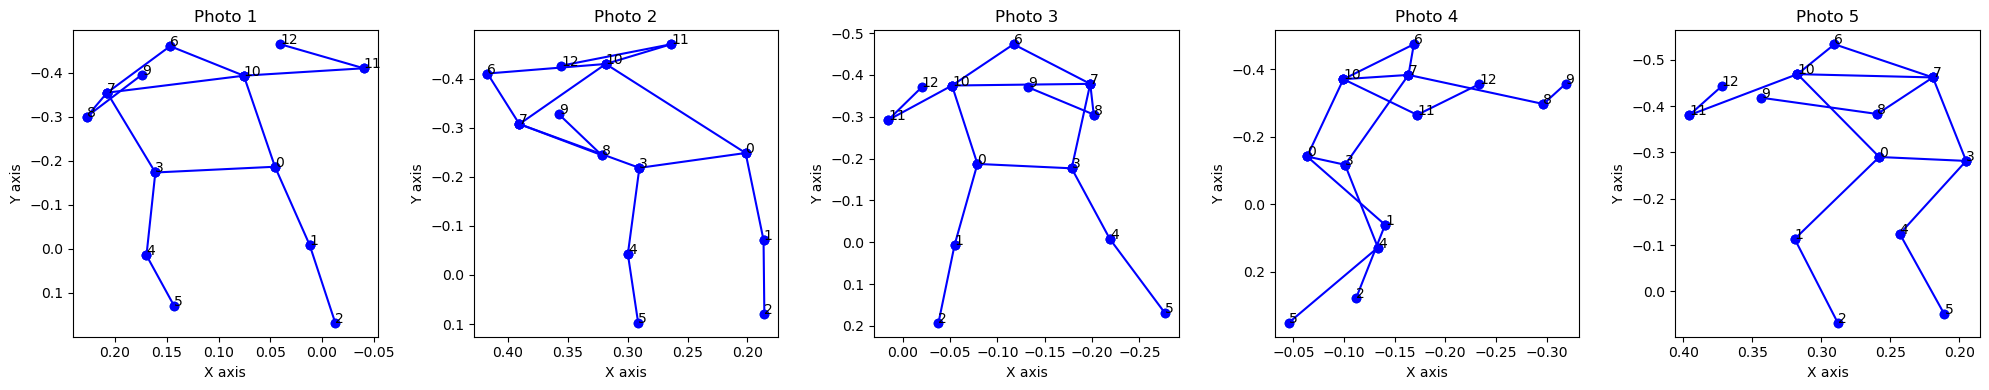

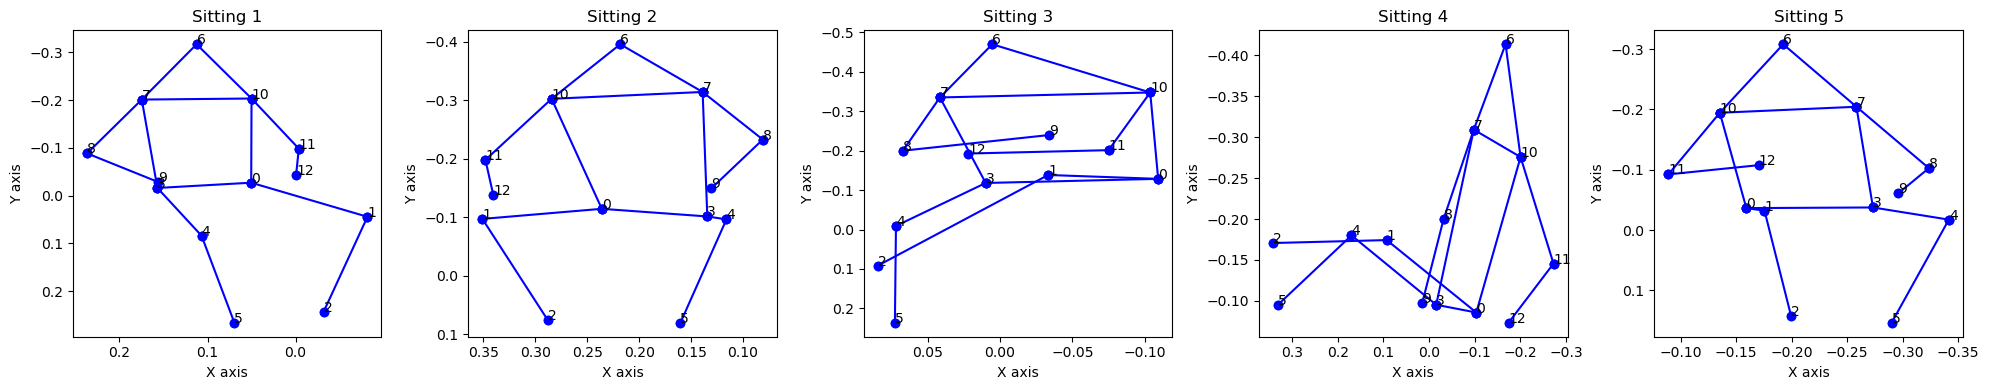

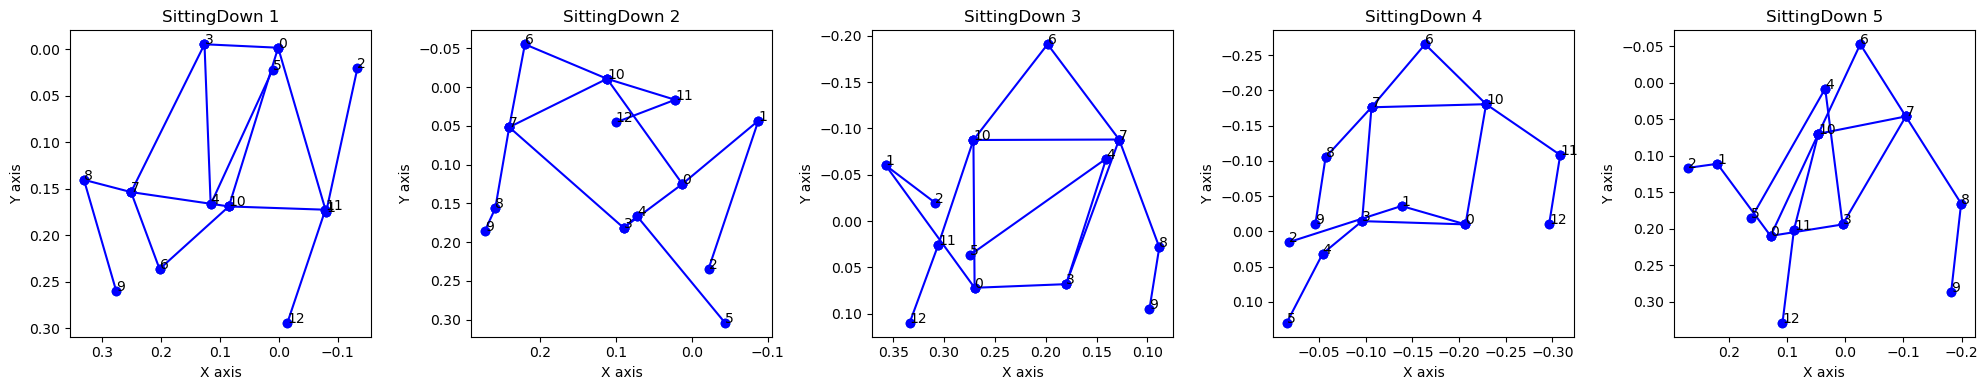

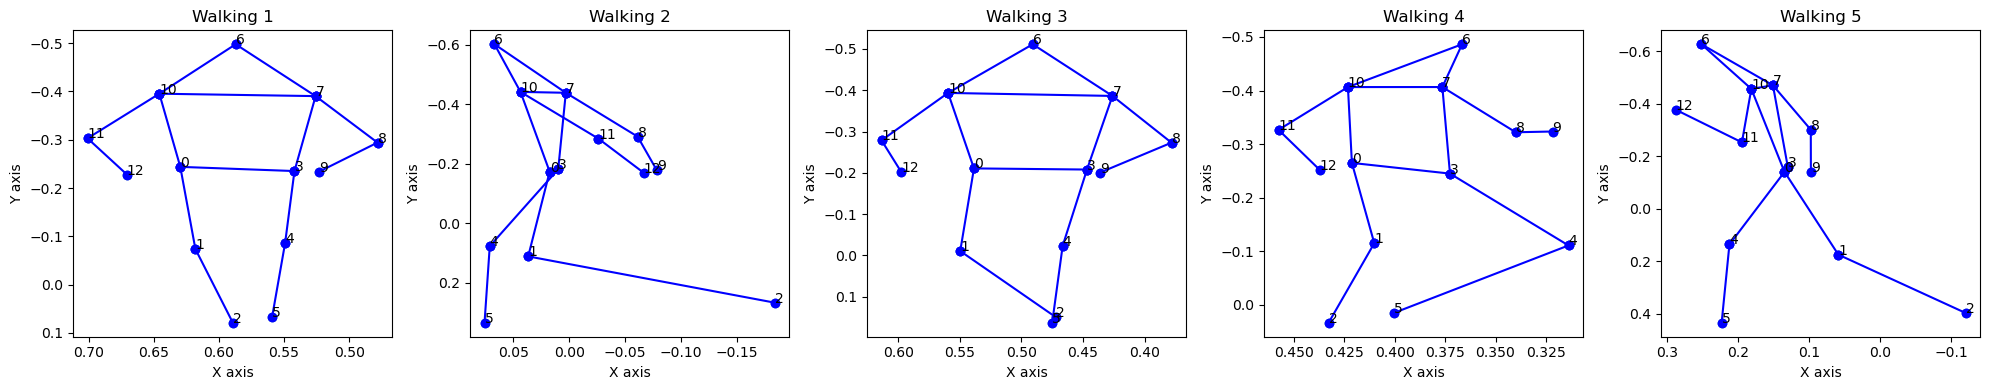

In [15]:
from utils.visualization_utils import visualize_2d_pose_actions

out_poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
out_actions = np.load("datasets/h36m/Processed/test_actions.npy")
for action in np.unique(out_actions):
    out_poses_2d_action = out_poses_2d[out_actions == action]
    visualize_2d_pose_actions(out_poses_2d_action, action=action)

Let's visualise the first 2D pose and corresponding 3D poses in the h3.6m dataset

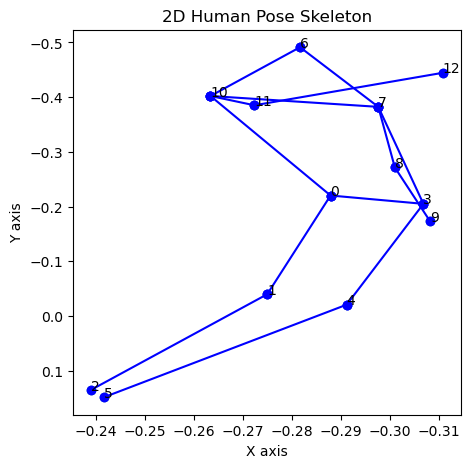

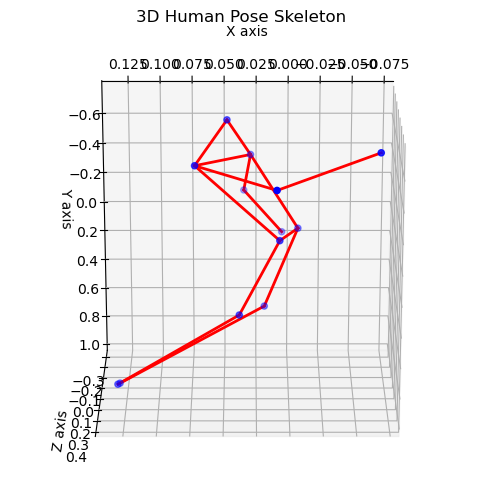

In [16]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

Let's visualise the distribution of the 5 actions in the h3.6m train and test datasets

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def show_action_stats(actions, type):
    train_actions_df = pd.DataFrame(actions, columns=['actions'])
    action_counts = train_actions_df['actions'].value_counts()
    print(action_counts)
    
    action_counts.plot(kind='bar')
    
    # Step 4: Show the plot
    plt.title(f'{type} Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()


actions
SittingDown    58356
Walking        48656
Photo          35552
Sitting        32976
Greeting       22312
Name: count, dtype: int64


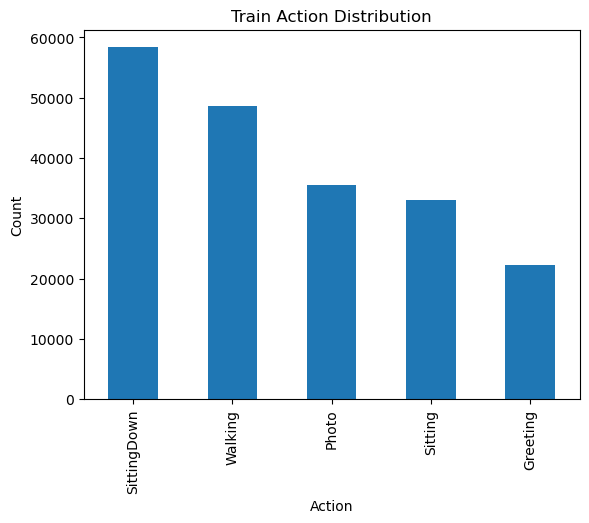

In [18]:
train_actions = np.load("datasets/h36m/Processed/train_actions.npy")
show_action_stats(train_actions, "Train")

actions
Sitting        18964
SittingDown    17492
Photo          15744
Greeting       11420
Walking        11332
Name: count, dtype: int64


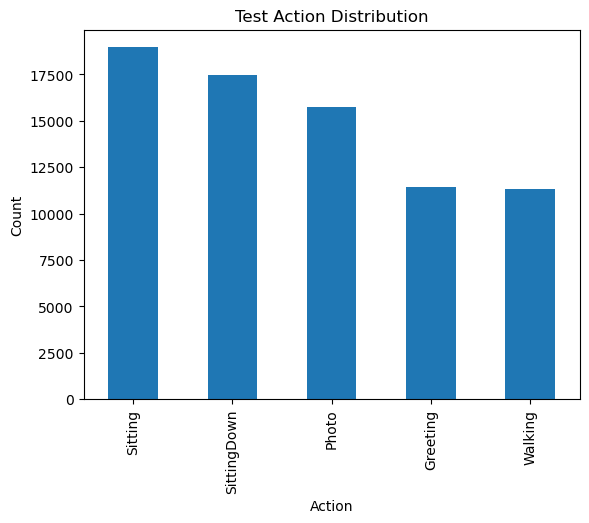

In [19]:
test_actions = np.load("datasets/h36m/Processed/test_actions.npy")
show_action_stats(test_actions, "Test")

**NOTE: do not run the cells below as the output contains our training execution logs**

<h3><u>3.4.  Training baseline model (SimplePose) </u></h3>

In [ ]:
from src.simple_pose.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/h36m/Processed/train_2d_poses.npy', training_3d_data_path='datasets/h36m/Processed/train_3d_poses.npy', training_label_path='datasets/h36m/Processed/train_actions.npy', testing_2d_data_path='datasets/h36m/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/h36m/Processed/test_3d_poses.npy', testing_label_path='datasets/h36m/Processed/test_actions.npy', save_path='model_outputs/simple_pose/2024-11-18--03-29-34')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.80it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 67.90802764892578 | Pose Training Loss: 0.6661983132362366 | Action Training Loss: 1.2881903648376465 | Action Train Label Accuracy: 49.450094009663786


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 207.49it/s]


Epoch: 0 | Total Testing Loss: 10.159862518310547 | Pose Testing Loss: 0.09032389521598816 | Action Testing Loss: 1.1274749040603638 | Action Test Label Accuracy: 44.87938947593126
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 90.46it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 13.317322731018066 | Pose Training Loss: 0.12374890595674515 | Action Training Loss: 0.9424268007278442 | Action Train Label Accuracy: 61.97309099731112


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 199.69it/s]


Epoch: 1 | Total Testing Loss: 9.401177406311035 | Pose Testing Loss: 0.08492902666330338 | Action Testing Loss: 0.9082731008529663 | Action Test Label Accuracy: 60.170509125840546
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 773/773 [00:09<00:00, 84.60it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 9.093670845031738 | Pose Training Loss: 0.08248811960220337 | Action Training Loss: 0.8448598384857178 | Action Train Label Accuracy: 65.86842690495926


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 194.67it/s]


Epoch: 2 | Total Testing Loss: 8.432327270507812 | Pose Testing Loss: 0.07607001811265945 | Action Testing Loss: 0.8253238201141357 | Action Test Label Accuracy: 61.251200768491834
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.42it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 7.556921005249023 | Pose Training Loss: 0.06775582581758499 | Action Training Loss: 0.7813431620597839 | Action Train Label Accuracy: 68.30459131067667


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 200.50it/s]


Epoch: 3 | Total Testing Loss: 7.191287517547607 | Pose Testing Loss: 0.06400567293167114 | Action Testing Loss: 0.7907236814498901 | Action Test Label Accuracy: 61.672803927847156
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.45it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 6.592976093292236 | Pose Training Loss: 0.058658014982938766 | Action Training Loss: 0.7271780967712402 | Action Train Label Accuracy: 70.4284010270303


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 188.69it/s]


Epoch: 4 | Total Testing Loss: 6.330264568328857 | Pose Testing Loss: 0.055767644196748734 | Action Testing Loss: 0.7535014748573303 | Action Test Label Accuracy: 65.1577009285943
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.38it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 5.937450885772705 | Pose Training Loss: 0.05259483680129051 | Action Training Loss: 0.6779706478118896 | Action Train Label Accuracy: 72.30556173301255


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 186.60it/s]


Epoch: 5 | Total Testing Loss: 5.743738174438477 | Pose Testing Loss: 0.05008965730667114 | Action Testing Loss: 0.7347736954689026 | Action Test Label Accuracy: 67.38312520012808
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 86.64it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 5.489512920379639 | Pose Training Loss: 0.04854542389512062 | Action Training Loss: 0.6349709033966064 | Action Train Label Accuracy: 73.98611083031761


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 191.09it/s]


Epoch: 6 | Total Testing Loss: 5.44240140914917 | Pose Testing Loss: 0.047397974878549576 | Action Testing Loss: 0.7026021480560303 | Action Test Label Accuracy: 69.18160956345393
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.09it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 5.1213178634643555 | Pose Training Loss: 0.04529615119099617 | Action Training Loss: 0.5917081236839294 | Action Train Label Accuracy: 75.68434991812062


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 189.59it/s]


Epoch: 7 | Total Testing Loss: 4.9338531494140625 | Pose Testing Loss: 0.04264993593096733 | Action Testing Loss: 0.6688589453697205 | Action Test Label Accuracy: 72.30093926779806
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 773/773 [00:09<00:00, 83.11it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 4.5529351234436035 | Pose Training Loss: 0.04001784697175026 | Action Training Loss: 0.5511538982391357 | Action Train Label Accuracy: 77.19305339344561


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 186.85it/s]


Epoch: 8 | Total Testing Loss: 4.201845645904541 | Pose Testing Loss: 0.03563755005598068 | Action Testing Loss: 0.6380928754806519 | Action Test Label Accuracy: 73.35227879176006
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.26it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 3.993389368057251 | Pose Training Loss: 0.034853097051382065 | Action Training Loss: 0.5080797076225281 | Action Train Label Accuracy: 78.9241453207448


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 191.44it/s]


Epoch: 9 | Total Testing Loss: 3.783137083053589 | Pose Testing Loss: 0.03165954723954201 | Action Testing Loss: 0.6171826124191284 | Action Test Label Accuracy: 72.51040666026257
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.35it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 3.621448516845703 | Pose Training Loss: 0.03153615817427635 | Action Training Loss: 0.4678322672843933 | Action Train Label Accuracy: 80.27616602308797


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 185.21it/s]


Epoch: 10 | Total Testing Loss: 3.5202810764312744 | Pose Testing Loss: 0.02918286994099617 | Action Testing Loss: 0.6019936203956604 | Action Test Label Accuracy: 73.07610203863806
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.70it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 3.3529458045959473 | Pose Training Loss: 0.02920670621097088 | Action Training Loss: 0.4322735369205475 | Action Train Label Accuracy: 81.52912277864263


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 200.38it/s]


Epoch: 11 | Total Testing Loss: 3.3044376373291016 | Pose Testing Loss: 0.027382267639040947 | Action Testing Loss: 0.5662111639976501 | Action Test Label Accuracy: 73.76454264062333
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 773/773 [00:09<00:00, 85.79it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 3.150153398513794 | Pose Training Loss: 0.027469748631119728 | Action Training Loss: 0.4031812250614166 | Action Train Label Accuracy: 82.55969108222307


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 192.89it/s]


Epoch: 12 | Total Testing Loss: 3.1328723430633545 | Pose Testing Loss: 0.025881623849272728 | Action Testing Loss: 0.5447086095809937 | Action Test Label Accuracy: 74.62909595474437
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.09it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 2.991849184036255 | Pose Training Loss: 0.026086872443556786 | Action Training Loss: 0.383163720369339 | Action Train Label Accuracy: 83.34714837353174


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 187.45it/s]


Epoch: 13 | Total Testing Loss: 2.9995830059051514 | Pose Testing Loss: 0.024666184559464455 | Action Testing Loss: 0.5329656600952148 | Action Test Label Accuracy: 73.62178460881631
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.62it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 2.8492672443389893 | Pose Training Loss: 0.02484394609928131 | Action Training Loss: 0.3648744821548462 | Action Train Label Accuracy: 84.19525706083336


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 189.97it/s]


Epoch: 14 | Total Testing Loss: 2.8553879261016846 | Pose Testing Loss: 0.02352043241262436 | Action Testing Loss: 0.5033434629440308 | Action Test Label Accuracy: 75.35756217312414
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 90.67it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 2.7181079387664795 | Pose Training Loss: 0.02373608946800232 | Action Training Loss: 0.3445011079311371 | Action Train Label Accuracy: 85.19448880981744


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 198.03it/s]


Epoch: 15 | Total Testing Loss: 2.748802900314331 | Pose Testing Loss: 0.022543946281075478 | Action Testing Loss: 0.49440687894821167 | Action Test Label Accuracy: 76.60502721741915
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.33it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 2.5984957218170166 | Pose Training Loss: 0.022661907598376274 | Action Training Loss: 0.3323032259941101 | Action Train Label Accuracy: 85.78028020944949


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 191.63it/s]


Epoch: 16 | Total Testing Loss: 2.6476969718933105 | Pose Testing Loss: 0.021586833521723747 | Action Testing Loss: 0.4890148937702179 | Action Test Label Accuracy: 77.28412850891237
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.22it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 2.476933240890503 | Pose Training Loss: 0.021577445790171623 | Action Training Loss: 0.3191906809806824 | Action Train Label Accuracy: 86.4621029860704


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 191.50it/s]


Epoch: 17 | Total Testing Loss: 2.5408387184143066 | Pose Testing Loss: 0.020494217053055763 | Action Testing Loss: 0.49141648411750793 | Action Test Label Accuracy: 77.32148575088056
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.20it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 2.362994432449341 | Pose Training Loss: 0.020540764555335045 | Action Training Loss: 0.30891937017440796 | Action Train Label Accuracy: 86.90839617491862


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 192.50it/s]


Epoch: 18 | Total Testing Loss: 2.3972830772399902 | Pose Testing Loss: 0.01918748766183853 | Action Testing Loss: 0.47853341698646545 | Action Test Label Accuracy: 77.42555235350625
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 85.94it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 2.25716233253479 | Pose Training Loss: 0.01958383619785309 | Action Training Loss: 0.2987786531448364 | Action Train Label Accuracy: 87.49368214625073


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 198.92it/s]


Epoch: 19 | Total Testing Loss: 2.3037171363830566 | Pose Testing Loss: 0.018255868926644325 | Action Testing Loss: 0.478129506111145 | Action Test Label Accuracy: 78.09798270893373
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 85.98it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 2.1603875160217285 | Pose Training Loss: 0.018710605800151825 | Action Training Loss: 0.28932762145996094 | Action Train Label Accuracy: 88.05672927238541


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 201.29it/s]


Epoch: 20 | Total Testing Loss: 2.202420473098755 | Pose Testing Loss: 0.0172923244535923 | Action Testing Loss: 0.4731874167919159 | Action Test Label Accuracy: 78.80910449354253
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.77it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 2.0820534229278564 | Pose Training Loss: 0.01801444962620735 | Action Training Loss: 0.28060972690582275 | Action Train Label Accuracy: 88.46966419343751


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 203.59it/s]


Epoch: 21 | Total Testing Loss: 2.146014928817749 | Pose Testing Loss: 0.016673142090439796 | Action Testing Loss: 0.4787006378173828 | Action Test Label Accuracy: 78.93318390436545
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.61it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 2.014954090118408 | Pose Training Loss: 0.017418377101421356 | Action Training Loss: 0.2731166481971741 | Action Train Label Accuracy: 88.80071972989911


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 200.25it/s]


Epoch: 22 | Total Testing Loss: 2.0792222023010254 | Pose Testing Loss: 0.01604240946471691 | Action Testing Loss: 0.47498077154159546 | Action Test Label Accuracy: 79.01190094994129
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.80it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 1.9614228010177612 | Pose Training Loss: 0.01694568432867527 | Action Training Loss: 0.2668544054031372 | Action Train Label Accuracy: 89.1828235246548


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 205.13it/s]


Epoch: 23 | Total Testing Loss: 2.0455479621887207 | Pose Testing Loss: 0.01563344895839691 | Action Testing Loss: 0.4822041690349579 | Action Test Label Accuracy: 78.91183690895507
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.04it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 1.9162569046020508 | Pose Training Loss: 0.016550790518522263 | Action Training Loss: 0.2611773610115051 | Action Train Label Accuracy: 89.48355336311991


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 202.95it/s]


Epoch: 24 | Total Testing Loss: 2.0270180702209473 | Pose Testing Loss: 0.015459494665265083 | Action Testing Loss: 0.48106804490089417 | Action Test Label Accuracy: 79.54424164798804
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.57it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 1.8780263662338257 | Pose Training Loss: 0.016232559457421303 | Action Training Loss: 0.2547699809074402 | Action Train Label Accuracy: 89.77973434688555


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 203.60it/s]


Epoch: 25 | Total Testing Loss: 2.0009090900421143 | Pose Testing Loss: 0.015222162008285522 | Action Testing Loss: 0.47869521379470825 | Action Test Label Accuracy: 79.72569110897642
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.05it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 1.8433687686920166 | Pose Training Loss: 0.015934042632579803 | Action Training Loss: 0.24996404349803925 | Action Train Label Accuracy: 90.02739421385682


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 201.79it/s]


Epoch: 26 | Total Testing Loss: 1.9760500192642212 | Pose Testing Loss: 0.01486216951161623 | Action Testing Loss: 0.48983389139175415 | Action Test Label Accuracy: 79.69633899028712
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 88.08it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 1.8160885572433472 | Pose Training Loss: 0.01568826474249363 | Action Training Loss: 0.24726277589797974 | Action Train Label Accuracy: 90.18407698683865


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 202.24it/s]


Epoch: 27 | Total Testing Loss: 1.9631050825119019 | Pose Testing Loss: 0.01477572787553072 | Action Testing Loss: 0.4855321943759918 | Action Test Label Accuracy: 79.99252855160636
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.39it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 1.7904362678527832 | Pose Training Loss: 0.015465200878679752 | Action Training Loss: 0.24391618371009827 | Action Train Label Accuracy: 90.27151608272851


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 199.11it/s]


Epoch: 28 | Total Testing Loss: 1.935573935508728 | Pose Testing Loss: 0.014570319093763828 | Action Testing Loss: 0.47854113578796387 | Action Test Label Accuracy: 80.01654392144306
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 773/773 [00:08<00:00, 87.04it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 1.7584266662597656 | Pose Training Loss: 0.015206225216388702 | Action Training Loss: 0.2378043234348297 | Action Train Label Accuracy: 90.50552938560136


Testing =>: 100%|██████████| 293/293 [00:01<00:00, 202.77it/s]


Epoch: 29 | Total Testing Loss: 1.9219890832901 | Pose Testing Loss: 0.014424951747059822 | Action Testing Loss: 0.479493111371994 | Action Test Label Accuracy: 80.16730707652899


<Figure size 640x480 with 0 Axes>

<h3><u>3.5.  Training Graph Convolutional model (SimplePoseGNN) </u></h3>

In [ ]:
from src.simple_pose_gnn.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gnn', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/h36m/Processed/train_2d_poses.npy', training_3d_data_path='datasets/h36m/Processed/train_3d_poses.npy', training_label_path='datasets/h36m/Processed/train_actions.npy', testing_2d_data_path='datasets/h36m/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/h36m/Processed/test_3d_poses.npy', testing_label_path='datasets/h36m/Processed/test_actions.npy', save_path='model_outputs/simple_pose_gnn/2024-11-18--03-35-29')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.08it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 14.24456787109375 | Pose Training Loss: 0.1294834166765213 | Action Training Loss: 1.2962241172790527 | Action Train Label Accuracy: 47.89842912884378


Testing =>: 100%|██████████| 293/293 [00:41<00:00,  7.10it/s]


Epoch: 0 | Total Testing Loss: 6.902277946472168 | Pose Testing Loss: 0.056832555681467056 | Action Testing Loss: 1.2190204858779907 | Action Test Label Accuracy: 54.039918881417435
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 773/773 [02:05<00:00,  6.14it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 6.95900821685791 | Pose Training Loss: 0.05998128280043602 | Action Training Loss: 0.9608767032623291 | Action Train Label Accuracy: 61.958433576612826


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.68it/s]


Epoch: 1 | Total Testing Loss: 5.613968849182129 | Pose Testing Loss: 0.04658839479088783 | Action Testing Loss: 0.9551315307617188 | Action Test Label Accuracy: 65.29111964990928
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.02it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 6.111195087432861 | Pose Training Loss: 0.05270753055810928 | Action Training Loss: 0.8404414653778076 | Action Train Label Accuracy: 65.491377393203


Testing =>: 100%|██████████| 293/293 [00:42<00:00,  6.95it/s]


Epoch: 2 | Total Testing Loss: 5.238968849182129 | Pose Testing Loss: 0.043737225234508514 | Action Testing Loss: 0.8652459383010864 | Action Test Label Accuracy: 67.35110470701248
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 773/773 [02:05<00:00,  6.15it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 5.614279747009277 | Pose Training Loss: 0.04829052835702896 | Action Training Loss: 0.7852303385734558 | Action Train Label Accuracy: 67.41301578958009


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.57it/s]


Epoch: 3 | Total Testing Loss: 4.790541648864746 | Pose Testing Loss: 0.039744868874549866 | Action Testing Loss: 0.8160549998283386 | Action Test Label Accuracy: 67.80606254669655
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.06it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 5.1178669929504395 | Pose Training Loss: 0.04367252066731453 | Action Training Loss: 0.750610888004303 | Action Train Label Accuracy: 68.64929341123668


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.64it/s]


Epoch: 4 | Total Testing Loss: 4.185216426849365 | Pose Testing Loss: 0.03396730124950409 | Action Testing Loss: 0.7884860634803772 | Action Test Label Accuracy: 68.78669014836161
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.04it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 4.721930980682373 | Pose Training Loss: 0.04005754739046097 | Action Training Loss: 0.7161731123924255 | Action Train Label Accuracy: 69.95077128358571


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


Epoch: 5 | Total Testing Loss: 3.896273374557495 | Pose Testing Loss: 0.03136249631643295 | Action Testing Loss: 0.7600265741348267 | Action Test Label Accuracy: 70.62520012808197
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.01it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 4.423716068267822 | Pose Training Loss: 0.03739633783698082 | Action Training Loss: 0.6840818524360657 | Action Train Label Accuracy: 71.42005135151528


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.72it/s]


Epoch: 6 | Total Testing Loss: 3.681725025177002 | Pose Testing Loss: 0.02962421253323555 | Action Testing Loss: 0.7193050384521484 | Action Test Label Accuracy: 72.23156153271427
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.08it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 4.170155048370361 | Pose Training Loss: 0.03525152429938316 | Action Training Loss: 0.6450006365776062 | Action Train Label Accuracy: 73.53880678486951


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.60it/s]


Epoch: 7 | Total Testing Loss: 3.547675132751465 | Pose Testing Loss: 0.028363855555653572 | Action Testing Loss: 0.7112874388694763 | Action Test Label Accuracy: 74.58239940228412
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.04it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 3.9506099224090576 | Pose Training Loss: 0.033505186438560486 | Action Training Loss: 0.6000866293907166 | Action Train Label Accuracy: 75.80009299880719


Testing =>: 100%|██████████| 293/293 [00:45<00:00,  6.44it/s]


Epoch: 8 | Total Testing Loss: 3.3562231063842773 | Pose Testing Loss: 0.026983175426721573 | Action Testing Loss: 0.657905638217926 | Action Test Label Accuracy: 74.52636353933184
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.99it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 3.7459120750427246 | Pose Training Loss: 0.03192107751965523 | Action Training Loss: 0.5538071393966675 | Action Train Label Accuracy: 77.82534419667226


Testing =>: 100%|██████████| 293/293 [00:42<00:00,  6.91it/s]


Epoch: 9 | Total Testing Loss: 3.1989402770996094 | Pose Testing Loss: 0.025823380798101425 | Action Testing Loss: 0.6166025400161743 | Action Test Label Accuracy: 74.14211762194472
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.05it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 3.5606913566589355 | Pose Training Loss: 0.030448883771896362 | Action Training Loss: 0.5158032774925232 | Action Train Label Accuracy: 79.08234437862644


Testing =>: 100%|██████████| 293/293 [00:45<00:00,  6.48it/s]


Epoch: 10 | Total Testing Loss: 3.0280048847198486 | Pose Testing Loss: 0.024350717663764954 | Action Testing Loss: 0.5929323434829712 | Action Test Label Accuracy: 74.91994876721103
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.06it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 3.396138906478882 | Pose Training Loss: 0.029067648574709892 | Action Training Loss: 0.48937416076660156 | Action Train Label Accuracy: 79.98756646382145


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


Epoch: 11 | Total Testing Loss: 2.8745768070220947 | Pose Testing Loss: 0.02299349755048752 | Action Testing Loss: 0.5752273797988892 | Action Test Label Accuracy: 74.57839684064467
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.02it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 3.2622063159942627 | Pose Training Loss: 0.027964739128947258 | Action Training Loss: 0.46573153138160706 | Action Train Label Accuracy: 80.79069203242828


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.60it/s]


Epoch: 12 | Total Testing Loss: 2.7292444705963135 | Pose Testing Loss: 0.02168227732181549 | Action Testing Loss: 0.5610177516937256 | Action Test Label Accuracy: 74.94663251147401
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.00it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 3.1434309482574463 | Pose Training Loss: 0.026996444910764694 | Action Training Loss: 0.44378480315208435 | Action Train Label Accuracy: 81.3845702848594


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.67it/s]


Epoch: 13 | Total Testing Loss: 2.6340222358703613 | Pose Testing Loss: 0.02075020782649517 | Action Testing Loss: 0.5590022206306458 | Action Test Label Accuracy: 74.65311132458106
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  5.99it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 3.037745475769043 | Pose Training Loss: 0.02611091546714306 | Action Training Loss: 0.426656037569046 | Action Train Label Accuracy: 82.20942927036371


Testing =>: 100%|██████████| 293/293 [00:45<00:00,  6.40it/s]


Epoch: 14 | Total Testing Loss: 2.52630615234375 | Pose Testing Loss: 0.019926678389310837 | Action Testing Loss: 0.5336376428604126 | Action Test Label Accuracy: 75.7965097662504
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.99it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 2.9412827491760254 | Pose Training Loss: 0.025308623909950256 | Action Training Loss: 0.41041994094848633 | Action Train Label Accuracy: 82.8336332207913


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.73it/s]


Epoch: 15 | Total Testing Loss: 2.468031644821167 | Pose Testing Loss: 0.01932913064956665 | Action Testing Loss: 0.5351172089576721 | Action Test Label Accuracy: 75.19479133311987
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.01it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 2.8524982929229736 | Pose Training Loss: 0.024567123502492905 | Action Training Loss: 0.3957851231098175 | Action Train Label Accuracy: 83.51899399551179


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.81it/s]


Epoch: 16 | Total Testing Loss: 2.4054713249206543 | Pose Testing Loss: 0.018712786957621574 | Action Testing Loss: 0.534191906452179 | Action Test Label Accuracy: 75.46029458853666
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.06it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 2.771574020385742 | Pose Training Loss: 0.023872578516602516 | Action Training Loss: 0.3843149244785309 | Action Train Label Accuracy: 83.98196631825809


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.56it/s]


Epoch: 17 | Total Testing Loss: 2.383622884750366 | Pose Testing Loss: 0.018381834030151367 | Action Testing Loss: 0.5454394221305847 | Action Test Label Accuracy: 74.88926246130858
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.02it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 2.6909327507019043 | Pose Training Loss: 0.02318444289267063 | Action Training Loss: 0.37248852849006653 | Action Train Label Accuracy: 84.46768291450175


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.52it/s]


Epoch: 18 | Total Testing Loss: 2.3235881328582764 | Pose Testing Loss: 0.01794619672000408 | Action Testing Loss: 0.528969407081604 | Action Test Label Accuracy: 75.44295015476573
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.03it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 2.622431755065918 | Pose Training Loss: 0.022597987204790115 | Action Training Loss: 0.3626313805580139 | Action Train Label Accuracy: 84.90892182035057


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.70it/s]


Epoch: 19 | Total Testing Loss: 2.302480936050415 | Pose Testing Loss: 0.017673665657639503 | Action Testing Loss: 0.5351141095161438 | Action Test Label Accuracy: 75.61772867968834
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.99it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 2.5644261837005615 | Pose Training Loss: 0.02210976928472519 | Action Training Loss: 0.35344839096069336 | Action Train Label Accuracy: 85.38351899399551


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.58it/s]


Epoch: 20 | Total Testing Loss: 2.2544870376586914 | Pose Testing Loss: 0.0173322893679142 | Action Testing Loss: 0.5212581157684326 | Action Test Label Accuracy: 75.62306542854094
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.07it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 2.5092051029205322 | Pose Training Loss: 0.0216500386595726 | Action Training Loss: 0.34420353174209595 | Action Train Label Accuracy: 85.79544305844773


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


Epoch: 21 | Total Testing Loss: 2.2271933555603027 | Pose Testing Loss: 0.017040828242897987 | Action Testing Loss: 0.523110568523407 | Action Test Label Accuracy: 76.13939588002988
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.02it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 2.4509453773498535 | Pose Training Loss: 0.02112911082804203 | Action Training Loss: 0.3380354642868042 | Action Train Label Accuracy: 86.08151547621455


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.63it/s]


Epoch: 22 | Total Testing Loss: 2.2179644107818604 | Pose Testing Loss: 0.01692955195903778 | Action Testing Loss: 0.5250096321105957 | Action Test Label Accuracy: 75.4963176432917
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 773/773 [02:11<00:00,  5.89it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 2.4017040729522705 | Pose Training Loss: 0.020703410729765892 | Action Training Loss: 0.3313647210597992 | Action Train Label Accuracy: 86.36455532418171


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.73it/s]


Epoch: 23 | Total Testing Loss: 2.1865556240081787 | Pose Testing Loss: 0.01658615842461586 | Action Testing Loss: 0.5279397964477539 | Action Test Label Accuracy: 75.37090404525563
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.01it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 2.3558084964752197 | Pose Training Loss: 0.020326217636466026 | Action Training Loss: 0.32318565249443054 | Action Train Label Accuracy: 86.81135394132988


Testing =>: 100%|██████████| 293/293 [00:42<00:00,  6.87it/s]


Epoch: 24 | Total Testing Loss: 2.156276226043701 | Pose Testing Loss: 0.016396021470427513 | Action Testing Loss: 0.5166754126548767 | Action Test Label Accuracy: 76.29682997118155
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.99it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 2.3149609565734863 | Pose Training Loss: 0.019966211169958115 | Action Training Loss: 0.31833988428115845 | Action Train Label Accuracy: 87.02262297070537


Testing =>: 100%|██████████| 293/293 [00:44<00:00,  6.66it/s]


Epoch: 25 | Total Testing Loss: 2.1293251514434814 | Pose Testing Loss: 0.016152309253811836 | Action Testing Loss: 0.5140926837921143 | Action Test Label Accuracy: 76.11137794855374
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.96it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 2.274895191192627 | Pose Training Loss: 0.01962411217391491 | Action Training Loss: 0.31248369812965393 | Action Train Label Accuracy: 87.23995713968017


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.70it/s]


Epoch: 26 | Total Testing Loss: 2.1191153526306152 | Pose Testing Loss: 0.015914160758256912 | Action Testing Loss: 0.5277003049850464 | Action Test Label Accuracy: 75.17477852492262
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 773/773 [02:08<00:00,  6.01it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 2.238274574279785 | Pose Training Loss: 0.01932295598089695 | Action Training Loss: 0.3059782087802887 | Action Train Label Accuracy: 87.61498493823666


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.73it/s]


Epoch: 27 | Total Testing Loss: 2.100525379180908 | Pose Testing Loss: 0.015697134658694267 | Action Testing Loss: 0.5308107733726501 | Action Test Label Accuracy: 75.98996691215712
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 773/773 [02:07<00:00,  6.04it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 2.2047061920166016 | Pose Training Loss: 0.0190326739102602 | Action Training Loss: 0.3014392852783203 | Action Train Label Accuracy: 87.71859773972464


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.72it/s]


Epoch: 28 | Total Testing Loss: 2.074083089828491 | Pose Testing Loss: 0.01551864854991436 | Action Testing Loss: 0.5222181677818298 | Action Test Label Accuracy: 76.39022307610203
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 773/773 [02:09<00:00,  5.96it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 2.1740164756774902 | Pose Training Loss: 0.018767505884170532 | Action Training Loss: 0.2972647547721863 | Action Train Label Accuracy: 87.96221418029639


Testing =>: 100%|██████████| 293/293 [00:43<00:00,  6.69it/s]


Epoch: 29 | Total Testing Loss: 2.0666732788085938 | Pose Testing Loss: 0.015275339595973492 | Action Testing Loss: 0.5391401052474976 | Action Test Label Accuracy: 76.09136514035649


<Figure size 640x480 with 0 Axes>

<h3><u>3.6.  Training Graph Transformer model (SimplePoseGAT) </u></h3>

In [ ]:
from src.simple_pose_gat.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/h36m/Processed/train_2d_poses.npy', training_3d_data_path='datasets/h36m/Processed/train_3d_poses.npy', training_label_path='datasets/h36m/Processed/train_actions.npy', testing_2d_data_path='datasets/h36m/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/h36m/Processed/test_3d_poses.npy', testing_label_path='datasets/h36m/Processed/test_actions.npy', save_path='model_outputs/simple_pose_gat/2024-11-18--05-02-06')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 773/773 [03:02<00:00,  4.24it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 7.1949896812438965 | Pose Training Loss: 0.059793420135974884 | Action Training Loss: 1.215651512145996 | Action Train Label Accuracy: 51.03713887147969


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.36it/s]


Epoch: 0 | Total Testing Loss: 3.8429837226867676 | Pose Testing Loss: 0.02562158741056919 | Action Testing Loss: 1.280826210975647 | Action Test Label Accuracy: 39.145052833813644
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 773/773 [03:00<00:00,  4.27it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 3.444185256958008 | Pose Training Loss: 0.02466331049799919 | Action Training Loss: 0.9778536558151245 | Action Train Label Accuracy: 57.75630269090028


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.35it/s]


Epoch: 1 | Total Testing Loss: 3.3796157836914062 | Pose Testing Loss: 0.022376131266355515 | Action Testing Loss: 1.1420021057128906 | Action Test Label Accuracy: 45.31566869463123
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 773/773 [03:01<00:00,  4.26it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 2.942357301712036 | Pose Training Loss: 0.020745350047945976 | Action Training Loss: 0.8678224682807922 | Action Train Label Accuracy: 65.81080807876594


Testing =>: 100%|██████████| 293/293 [01:04<00:00,  4.52it/s]


Epoch: 2 | Total Testing Loss: 3.0136005878448486 | Pose Testing Loss: 0.020053265616297722 | Action Testing Loss: 1.0082733631134033 | Action Test Label Accuracy: 58.17856761660797
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 773/773 [02:59<00:00,  4.31it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 2.58655047416687 | Pose Training Loss: 0.01827201619744301 | Action Training Loss: 0.7593502402305603 | Action Train Label Accuracy: 68.40466611406507


Testing =>: 100%|██████████| 293/293 [01:05<00:00,  4.45it/s]


Epoch: 3 | Total Testing Loss: 2.714442491531372 | Pose Testing Loss: 0.018223971128463745 | Action Testing Loss: 0.8920454382896423 | Action Test Label Accuracy: 62.16245063507312
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 773/773 [03:01<00:00,  4.26it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 2.3477094173431396 | Pose Training Loss: 0.016604550182819366 | Action Training Loss: 0.687252938747406 | Action Train Label Accuracy: 71.08444696035421


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.36it/s]


Epoch: 4 | Total Testing Loss: 2.5274741649627686 | Pose Testing Loss: 0.017077218741178513 | Action Testing Loss: 0.819752037525177 | Action Test Label Accuracy: 65.89150389582666
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 773/773 [03:01<00:00,  4.27it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 2.178523540496826 | Pose Training Loss: 0.015382269397377968 | Action Training Loss: 0.6402955055236816 | Action Train Label Accuracy: 73.31894547439501


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.37it/s]


Epoch: 5 | Total Testing Loss: 2.410928964614868 | Pose Testing Loss: 0.01612262614071369 | Action Testing Loss: 0.7986662983894348 | Action Test Label Accuracy: 65.90751414238446
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 773/773 [03:03<00:00,  4.21it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 2.038505792617798 | Pose Training Loss: 0.014407350681722164 | Action Training Loss: 0.5977694988250732 | Action Train Label Accuracy: 75.40131007015344


Testing =>: 100%|██████████| 293/293 [01:04<00:00,  4.51it/s]


Epoch: 6 | Total Testing Loss: 2.2700605392456055 | Pose Testing Loss: 0.015247193165123463 | Action Testing Loss: 0.7453401684761047 | Action Test Label Accuracy: 69.24031380083252
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 773/773 [03:04<00:00,  4.20it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 1.9062386751174927 | Pose Training Loss: 0.013573587872087955 | Action Training Loss: 0.5488809943199158 | Action Train Label Accuracy: 77.54078806380527


Testing =>: 100%|██████████| 293/293 [01:05<00:00,  4.47it/s]


Epoch: 7 | Total Testing Loss: 2.1207778453826904 | Pose Testing Loss: 0.014292314648628235 | Action Testing Loss: 0.6915462017059326 | Action Test Label Accuracy: 71.31630910449354
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 773/773 [02:58<00:00,  4.34it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 1.7855520248413086 | Pose Training Loss: 0.01288048829883337 | Action Training Loss: 0.49750229716300964 | Action Train Label Accuracy: 79.51246386187655


Testing =>: 100%|██████████| 293/293 [01:05<00:00,  4.50it/s]


Epoch: 8 | Total Testing Loss: 2.002653121948242 | Pose Testing Loss: 0.01354646123945713 | Action Testing Loss: 0.6480077505111694 | Action Test Label Accuracy: 71.58448073433664
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 773/773 [02:57<00:00,  4.35it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 1.6788734197616577 | Pose Training Loss: 0.01227924320846796 | Action Training Loss: 0.45094922184944153 | Action Train Label Accuracy: 81.28196833997129


Testing =>: 100%|██████████| 293/293 [01:04<00:00,  4.54it/s]


Epoch: 9 | Total Testing Loss: 1.9319472312927246 | Pose Testing Loss: 0.013065802864730358 | Action Testing Loss: 0.6253674030303955 | Action Test Label Accuracy: 72.21288291173018
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 773/773 [03:02<00:00,  4.24it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 1.5892566442489624 | Pose Training Loss: 0.011774557642638683 | Action Training Loss: 0.41180112957954407 | Action Train Label Accuracy: 82.9129854638821


Testing =>: 100%|██████████| 293/293 [01:06<00:00,  4.43it/s]


Epoch: 10 | Total Testing Loss: 1.9046974182128906 | Pose Testing Loss: 0.012752491049468517 | Action Testing Loss: 0.6294487714767456 | Action Test Label Accuracy: 70.82666239726758
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 773/773 [03:04<00:00,  4.18it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 1.5151386260986328 | Pose Training Loss: 0.011346127837896347 | Action Training Loss: 0.38052669167518616 | Action Train Label Accuracy: 84.12752966864122


Testing =>: 100%|██████████| 293/293 [01:08<00:00,  4.28it/s]


Epoch: 11 | Total Testing Loss: 1.8511673212051392 | Pose Testing Loss: 0.012197420001029968 | Action Testing Loss: 0.631425678730011 | Action Test Label Accuracy: 70.7199274202156
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 773/773 [03:01<00:00,  4.26it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 1.4517066478729248 | Pose Training Loss: 0.01096460223197937 | Action Training Loss: 0.35524705052375793 | Action Train Label Accuracy: 85.18640195701838


Testing =>: 100%|██████████| 293/293 [01:09<00:00,  4.20it/s]


Epoch: 12 | Total Testing Loss: 1.8649733066558838 | Pose Testing Loss: 0.012367656454443932 | Action Testing Loss: 0.6282076239585876 | Action Test Label Accuracy: 71.4977585654819
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 773/773 [03:02<00:00,  4.23it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 1.4009335041046143 | Pose Training Loss: 0.010659613646566868 | Action Training Loss: 0.33497121930122375 | Action Train Label Accuracy: 86.0405757839193


Testing =>: 100%|██████████| 293/293 [01:09<00:00,  4.21it/s]


Epoch: 13 | Total Testing Loss: 1.8134418725967407 | Pose Testing Loss: 0.01175545621663332 | Action Testing Loss: 0.6378965377807617 | Action Test Label Accuracy: 70.95607855694311
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 773/773 [03:00<00:00,  4.29it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 1.3571081161499023 | Pose Training Loss: 0.010385510511696339 | Action Training Loss: 0.31855738162994385 | Action Train Label Accuracy: 86.6844914380446


Testing =>: 100%|██████████| 293/293 [01:08<00:00,  4.26it/s]


Epoch: 14 | Total Testing Loss: 1.8263996839523315 | Pose Testing Loss: 0.011569444090127945 | Action Testing Loss: 0.6694549322128296 | Action Test Label Accuracy: 69.92475184117836
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 773/773 [03:03<00:00,  4.22it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 1.314896583557129 | Pose Training Loss: 0.01010789442807436 | Action Training Loss: 0.3041064441204071 | Action Train Label Accuracy: 87.3637870731658


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.32it/s]


Epoch: 15 | Total Testing Loss: 1.805808424949646 | Pose Testing Loss: 0.011365019716322422 | Action Testing Loss: 0.6693060398101807 | Action Test Label Accuracy: 70.64788131070551
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 773/773 [03:05<00:00,  4.16it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 1.283589482307434 | Pose Training Loss: 0.0098861213773489 | Action Training Loss: 0.29497697949409485 | Action Train Label Accuracy: 87.77217313951843


Testing =>: 100%|██████████| 293/293 [01:09<00:00,  4.23it/s]


Epoch: 16 | Total Testing Loss: 1.7875163555145264 | Pose Testing Loss: 0.01110229641199112 | Action Testing Loss: 0.6772866249084473 | Action Test Label Accuracy: 70.92138968940121
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 773/773 [03:00<00:00,  4.29it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 1.251349687576294 | Pose Training Loss: 0.009670587256550789 | Action Training Loss: 0.2842908799648285 | Action Train Label Accuracy: 88.24929745466308


Testing =>: 100%|██████████| 293/293 [01:09<00:00,  4.19it/s]


Epoch: 17 | Total Testing Loss: 1.7813336849212646 | Pose Testing Loss: 0.01104812417179346 | Action Testing Loss: 0.6765217781066895 | Action Test Label Accuracy: 71.13085708186573
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 773/773 [03:05<00:00,  4.16it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 1.221678376197815 | Pose Training Loss: 0.009470864199101925 | Action Training Loss: 0.27459219098091125 | Action Train Label Accuracy: 88.67840608131331


Testing =>: 100%|██████████| 293/293 [01:06<00:00,  4.43it/s]


Epoch: 18 | Total Testing Loss: 1.7774319648742676 | Pose Testing Loss: 0.010923095978796482 | Action Testing Loss: 0.6851223111152649 | Action Test Label Accuracy: 71.22558437399937
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 773/773 [03:00<00:00,  4.29it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 1.1953538656234741 | Pose Training Loss: 0.009285707958042622 | Action Training Loss: 0.26678308844566345 | Action Train Label Accuracy: 89.05848816286922


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.33it/s]


Epoch: 19 | Total Testing Loss: 1.7296197414398193 | Pose Testing Loss: 0.010439693927764893 | Action Testing Loss: 0.6856498122215271 | Action Test Label Accuracy: 71.40703383498771
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 773/773 [03:01<00:00,  4.27it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 1.1702373027801514 | Pose Training Loss: 0.00911403726786375 | Action Training Loss: 0.2588336765766144 | Action Train Label Accuracy: 89.3344520146372


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.36it/s]


Epoch: 20 | Total Testing Loss: 1.7152788639068604 | Pose Testing Loss: 0.010393538512289524 | Action Testing Loss: 0.6759255528450012 | Action Test Label Accuracy: 71.68854733696233
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 773/773 [03:07<00:00,  4.12it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 1.1465879678726196 | Pose Training Loss: 0.008949191309511662 | Action Training Loss: 0.2516690790653229 | Action Train Label Accuracy: 89.73272951499101


Testing =>: 100%|██████████| 293/293 [01:06<00:00,  4.38it/s]


Epoch: 21 | Total Testing Loss: 1.7343599796295166 | Pose Testing Loss: 0.010229090228676796 | Action Testing Loss: 0.71145099401474 | Action Test Label Accuracy: 71.43505176646387
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 773/773 [03:07<00:00,  4.12it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 1.1236053705215454 | Pose Training Loss: 0.008784964680671692 | Action Training Loss: 0.24510911107063293 | Action Train Label Accuracy: 90.08248589855043


Testing =>: 100%|██████████| 293/293 [01:05<00:00,  4.46it/s]


Epoch: 22 | Total Testing Loss: 1.7118964195251465 | Pose Testing Loss: 0.010029437951743603 | Action Testing Loss: 0.7089531421661377 | Action Test Label Accuracy: 71.45373038744796
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 773/773 [02:57<00:00,  4.35it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 1.1018474102020264 | Pose Training Loss: 0.008635145612061024 | Action Training Loss: 0.2383333444595337 | Action Train Label Accuracy: 90.38928087661485


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.31it/s]


Epoch: 23 | Total Testing Loss: 1.6595417261123657 | Pose Testing Loss: 0.009800991974771023 | Action Testing Loss: 0.6794428825378418 | Action Test Label Accuracy: 72.68651937239834
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 773/773 [03:07<00:00,  4.12it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 1.0832127332687378 | Pose Training Loss: 0.008500310592353344 | Action Training Loss: 0.23318108916282654 | Action Train Label Accuracy: 90.67838586418131


Testing =>: 100%|██████████| 293/293 [01:05<00:00,  4.48it/s]


Epoch: 24 | Total Testing Loss: 1.6504318714141846 | Pose Testing Loss: 0.009559398517012596 | Action Testing Loss: 0.6944918036460876 | Action Test Label Accuracy: 72.95068844060198
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 773/773 [03:02<00:00,  4.23it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 1.061116099357605 | Pose Training Loss: 0.008352267555892467 | Action Training Loss: 0.2258891463279724 | Action Train Label Accuracy: 90.91846430665346


Testing =>: 100%|██████████| 293/293 [01:06<00:00,  4.43it/s]


Epoch: 25 | Total Testing Loss: 1.660233974456787 | Pose Testing Loss: 0.009524350054562092 | Action Testing Loss: 0.7077985405921936 | Action Test Label Accuracy: 72.6051339523962
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 773/773 [03:07<00:00,  4.12it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 1.0423977375030518 | Pose Training Loss: 0.008223796263337135 | Action Training Loss: 0.220017209649086 | Action Train Label Accuracy: 91.25558498271435


Testing =>: 100%|██████████| 293/293 [01:08<00:00,  4.30it/s]


Epoch: 26 | Total Testing Loss: 1.6271312236785889 | Pose Testing Loss: 0.009221832267940044 | Action Testing Loss: 0.7049478888511658 | Action Test Label Accuracy: 73.0961148468353
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 773/773 [03:03<00:00,  4.21it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 1.02488374710083 | Pose Training Loss: 0.008102689869701862 | Action Training Loss: 0.2146151065826416 | Action Train Label Accuracy: 91.52144026848352


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.33it/s]


Epoch: 27 | Total Testing Loss: 1.6269428730010986 | Pose Testing Loss: 0.009455295279622078 | Action Testing Loss: 0.6814125180244446 | Action Test Label Accuracy: 74.02604333440068
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 773/773 [03:04<00:00,  4.20it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 1.0073515176773071 | Pose Training Loss: 0.007986234501004219 | Action Training Loss: 0.20872777700424194 | Action Train Label Accuracy: 91.7276550148596


Testing =>: 100%|██████████| 293/293 [01:04<00:00,  4.53it/s]


Epoch: 28 | Total Testing Loss: 1.6136878728866577 | Pose Testing Loss: 0.009062003344297409 | Action Testing Loss: 0.7074874639511108 | Action Test Label Accuracy: 73.92597929341446
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 773/773 [03:02<00:00,  4.24it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 0.9923760890960693 | Pose Training Loss: 0.007883653976023197 | Action Training Loss: 0.20401187241077423 | Action Train Label Accuracy: 91.93841861593515


Testing =>: 100%|██████████| 293/293 [01:07<00:00,  4.33it/s]


Epoch: 29 | Total Testing Loss: 1.6089502573013306 | Pose Testing Loss: 0.00904751941561699 | Action Testing Loss: 0.7041975259780884 | Action Test Label Accuracy: 73.60977692389797


<Figure size 640x480 with 0 Axes>

<h3><u>3.7.  Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG) </u></h3>

In [ ]:
from src.simple_pose_tag.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_tag', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/h36m/Processed/train_2d_poses.npy', training_3d_data_path='datasets/h36m/Processed/train_3d_poses.npy', training_label_path='datasets/h36m/Processed/train_actions.npy', testing_2d_data_path='datasets/h36m/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/h36m/Processed/test_3d_poses.npy', testing_label_path='datasets/h36m/Processed/test_actions.npy', save_path='model_outputs/simple_pose_tag/2024-11-18--07-07-28')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 773/773 [02:32<00:00,  5.06it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 12.531847953796387 | Pose Training Loss: 0.11242948472499847 | Action Training Loss: 1.288909673690796 | Action Train Label Accuracy: 47.1888077957261


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.97it/s]


Epoch: 0 | Total Testing Loss: 5.952681064605713 | Pose Testing Loss: 0.04794268682599068 | Action Testing Loss: 1.1584112644195557 | Action Test Label Accuracy: 59.213896894012166
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 773/773 [02:31<00:00,  5.09it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 6.103329181671143 | Pose Training Loss: 0.05160829424858093 | Action Training Loss: 0.9425012469291687 | Action Train Label Accuracy: 62.12876291369306


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.88it/s]


Epoch: 1 | Total Testing Loss: 4.900516033172607 | Pose Testing Loss: 0.0394231453537941 | Action Testing Loss: 0.9582024216651917 | Action Test Label Accuracy: 64.62002348169496
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  5.01it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 5.080974102020264 | Pose Training Loss: 0.04277831315994263 | Action Training Loss: 0.8031438589096069 | Action Train Label Accuracy: 68.20855993368781


Testing =>: 100%|██████████| 293/293 [00:47<00:00,  6.14it/s]


Epoch: 2 | Total Testing Loss: 3.946298599243164 | Pose Testing Loss: 0.03142324090003967 | Action Testing Loss: 0.8039747476577759 | Action Test Label Accuracy: 69.34838296509767
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  5.02it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 4.4181904792785645 | Pose Training Loss: 0.03723902255296707 | Action Training Loss: 0.6942931413650513 | Action Train Label Accuracy: 72.77914805005761


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.97it/s]


Epoch: 3 | Total Testing Loss: 3.379633665084839 | Pose Testing Loss: 0.026839004829525948 | Action Testing Loss: 0.6957331895828247 | Action Test Label Accuracy: 71.95405059237913
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.95it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 3.9424831867218018 | Pose Training Loss: 0.03327079117298126 | Action Training Loss: 0.615408182144165 | Action Train Label Accuracy: 75.87085296079898


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.83it/s]


Epoch: 4 | Total Testing Loss: 3.021266222000122 | Pose Testing Loss: 0.023512249812483788 | Action Testing Loss: 0.6700426340103149 | Action Test Label Accuracy: 72.5837869569858
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  5.01it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 3.5088512897491455 | Pose Training Loss: 0.02953207679092884 | Action Training Loss: 0.5556424856185913 | Action Train Label Accuracy: 78.00072781675192


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  5.99it/s]


Epoch: 5 | Total Testing Loss: 2.532979726791382 | Pose Testing Loss: 0.01916775107383728 | Action Testing Loss: 0.6162049770355225 | Action Test Label Accuracy: 73.24020706585547
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.98it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 3.1497530937194824 | Pose Training Loss: 0.02647087536752224 | Action Training Loss: 0.5026674866676331 | Action Train Label Accuracy: 79.78387885894507


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.82it/s]


Epoch: 6 | Total Testing Loss: 2.4082231521606445 | Pose Testing Loss: 0.01764560677111149 | Action Testing Loss: 0.643661379814148 | Action Test Label Accuracy: 70.81065215070979
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.97it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 2.8832478523254395 | Pose Training Loss: 0.02423618547618389 | Action Training Loss: 0.4596301019191742 | Action Train Label Accuracy: 81.25669692497422


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.80it/s]


Epoch: 7 | Total Testing Loss: 2.1710667610168457 | Pose Testing Loss: 0.016147485002875328 | Action Testing Loss: 0.5563179850578308 | Action Test Label Accuracy: 75.22414345180916
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.96it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 2.671098470687866 | Pose Training Loss: 0.022525746375322342 | Action Training Loss: 0.4185214340686798 | Action Train Label Accuracy: 82.83211693589148


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.82it/s]


Epoch: 8 | Total Testing Loss: 2.0382018089294434 | Pose Testing Loss: 0.014884443953633308 | Action Testing Loss: 0.5497581362724304 | Action Test Label Accuracy: 75.08405379442843
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.96it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 2.4986467361450195 | Pose Training Loss: 0.021149098873138428 | Action Training Loss: 0.3837350606918335 | Action Train Label Accuracy: 84.27056587752462


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.91it/s]


Epoch: 9 | Total Testing Loss: 1.9497090578079224 | Pose Testing Loss: 0.014174461364746094 | Action Testing Loss: 0.532262921333313 | Action Test Label Accuracy: 75.52433557476786
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.97it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 2.3459129333496094 | Pose Training Loss: 0.01992831751704216 | Action Training Loss: 0.3530810475349426 | Action Train Label Accuracy: 85.48157208418414


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  6.08it/s]


Epoch: 10 | Total Testing Loss: 1.8437055349349976 | Pose Testing Loss: 0.01318137813359499 | Action Testing Loss: 0.5255671143531799 | Action Test Label Accuracy: 75.83520119543175
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  4.99it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 2.2162890434265137 | Pose Training Loss: 0.018873782828450203 | Action Training Loss: 0.32891005277633667 | Action Train Label Accuracy: 86.6698340173463


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.93it/s]


Epoch: 11 | Total Testing Loss: 1.8206439018249512 | Pose Testing Loss: 0.012726114131510258 | Action Testing Loss: 0.5480331182479858 | Action Test Label Accuracy: 75.70044828690362
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  5.00it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 2.096369981765747 | Pose Training Loss: 0.017900733277201653 | Action Training Loss: 0.3062981367111206 | Action Train Label Accuracy: 87.68574490022846


Testing =>: 100%|██████████| 293/293 [00:47<00:00,  6.22it/s]


Epoch: 12 | Total Testing Loss: 1.6981862783432007 | Pose Testing Loss: 0.011941284872591496 | Action Testing Loss: 0.5040577054023743 | Action Test Label Accuracy: 78.35681502828477
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.98it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 2.002490758895874 | Pose Training Loss: 0.017141109332442284 | Action Training Loss: 0.28837850689888 | Action Train Label Accuracy: 88.50554960273335


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  6.10it/s]


Epoch: 13 | Total Testing Loss: 1.6291958093643188 | Pose Testing Loss: 0.011365910060703754 | Action Testing Loss: 0.4926055073738098 | Action Test Label Accuracy: 78.30878428861138
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 773/773 [02:37<00:00,  4.92it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 1.921250820159912 | Pose Training Loss: 0.016486790031194687 | Action Training Loss: 0.2725701928138733 | Action Train Label Accuracy: 89.24701291874734


Testing =>: 100%|██████████| 293/293 [00:46<00:00,  6.29it/s]


Epoch: 14 | Total Testing Loss: 1.6658108234405518 | Pose Testing Loss: 0.011168825440108776 | Action Testing Loss: 0.5489289164543152 | Action Test Label Accuracy: 76.9092219020173
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 773/773 [02:34<00:00,  5.01it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 1.849032998085022 | Pose Training Loss: 0.015896202996373177 | Action Training Loss: 0.25941038131713867 | Action Train Label Accuracy: 89.72110466409235


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  5.98it/s]


Epoch: 15 | Total Testing Loss: 1.6368426084518433 | Pose Testing Loss: 0.010743698105216026 | Action Testing Loss: 0.5624720454216003 | Action Test Label Accuracy: 76.78781086562067
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.96it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 1.7877837419509888 | Pose Training Loss: 0.015412535518407822 | Action Training Loss: 0.2465299367904663 | Action Train Label Accuracy: 90.3508683258193


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.89it/s]


Epoch: 16 | Total Testing Loss: 1.5243390798568726 | Pose Testing Loss: 0.010083844885230064 | Action Testing Loss: 0.5159547328948975 | Action Test Label Accuracy: 78.83311986337922
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.93it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 1.7343336343765259 | Pose Training Loss: 0.014988462440669537 | Action Training Loss: 0.23548683524131775 | Action Train Label Accuracy: 90.79362351656795


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.86it/s]


Epoch: 17 | Total Testing Loss: 1.5226242542266846 | Pose Testing Loss: 0.010042538866400719 | Action Testing Loss: 0.5183697938919067 | Action Test Label Accuracy: 78.90650016010247
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.94it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 1.6912972927093506 | Pose Training Loss: 0.014626136980950832 | Action Training Loss: 0.22868451476097107 | Action Train Label Accuracy: 91.16764045852456


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  6.04it/s]


Epoch: 18 | Total Testing Loss: 1.4773809909820557 | Pose Testing Loss: 0.009518374688923359 | Action Testing Loss: 0.525543212890625 | Action Test Label Accuracy: 78.66234390009606
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 773/773 [02:38<00:00,  4.89it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 1.6442738771438599 | Pose Training Loss: 0.014252201654016972 | Action Training Loss: 0.21905438601970673 | Action Train Label Accuracy: 91.55176596647999


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  5.98it/s]


Epoch: 19 | Total Testing Loss: 1.5038995742797852 | Pose Testing Loss: 0.009521625936031342 | Action Testing Loss: 0.5517366528511047 | Action Test Label Accuracy: 79.31609563453944
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.95it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 1.6017539501190186 | Pose Training Loss: 0.01393539272248745 | Action Training Loss: 0.20821508765220642 | Action Train Label Accuracy: 91.98239087803005


Testing =>: 100%|██████████| 293/293 [00:47<00:00,  6.12it/s]


Epoch: 20 | Total Testing Loss: 1.4224518537521362 | Pose Testing Loss: 0.008897766470909119 | Action Testing Loss: 0.5326749086380005 | Action Test Label Accuracy: 79.72702529618955
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.94it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 1.567823886871338 | Pose Training Loss: 0.013664193451404572 | Action Training Loss: 0.20140370726585388 | Action Train Label Accuracy: 92.29171299759416


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.84it/s]


Epoch: 21 | Total Testing Loss: 1.5255506038665771 | Pose Testing Loss: 0.009284477680921555 | Action Testing Loss: 0.5971028804779053 | Action Test Label Accuracy: 79.29875120076849
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 773/773 [02:38<00:00,  4.88it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 1.5332285165786743 | Pose Training Loss: 0.013374797999858856 | Action Training Loss: 0.19574961066246033 | Action Train Label Accuracy: 92.59496997755899


Testing =>: 100%|██████████| 293/293 [00:50<00:00,  5.85it/s]


Epoch: 22 | Total Testing Loss: 1.4175057411193848 | Pose Testing Loss: 0.008516757749021053 | Action Testing Loss: 0.5658298134803772 | Action Test Label Accuracy: 79.45885366634646
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.95it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 1.49898099899292 | Pose Training Loss: 0.013124112971127033 | Action Training Loss: 0.18656998872756958 | Action Train Label Accuracy: 92.8759881123264


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.88it/s]


Epoch: 23 | Total Testing Loss: 1.3218104839324951 | Pose Testing Loss: 0.008131842128932476 | Action Testing Loss: 0.5086265206336975 | Action Test Label Accuracy: 81.16394492475185
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 773/773 [02:37<00:00,  4.92it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 1.4707088470458984 | Pose Training Loss: 0.01290122326463461 | Action Training Loss: 0.1805848926305771 | Action Train Label Accuracy: 93.19693508278915


Testing =>: 100%|██████████| 293/293 [00:47<00:00,  6.14it/s]


Epoch: 24 | Total Testing Loss: 1.3546949625015259 | Pose Testing Loss: 0.008314586244523525 | Action Testing Loss: 0.5232363343238831 | Action Test Label Accuracy: 80.80771693884085
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 773/773 [02:35<00:00,  4.96it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 1.4469056129455566 | Pose Training Loss: 0.012721731327474117 | Action Training Loss: 0.17473159730434418 | Action Train Label Accuracy: 93.43347552716172


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.88it/s]


Epoch: 25 | Total Testing Loss: 1.4257441759109497 | Pose Testing Loss: 0.008563335984945297 | Action Testing Loss: 0.569411039352417 | Action Test Label Accuracy: 80.71699220834667
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.92it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 1.4228088855743408 | Pose Training Loss: 0.012543092481791973 | Action Training Loss: 0.16850054264068604 | Action Train Label Accuracy: 93.67102682813416


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  6.08it/s]


Epoch: 26 | Total Testing Loss: 1.4382795095443726 | Pose Testing Loss: 0.008160050958395004 | Action Testing Loss: 0.6222734451293945 | Action Test Label Accuracy: 80.00320204931157
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.93it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 1.4016790390014648 | Pose Training Loss: 0.012392840348184109 | Action Training Loss: 0.1623944491147995 | Action Train Label Accuracy: 93.99904979479611


Testing =>: 100%|██████████| 293/293 [00:47<00:00,  6.12it/s]


Epoch: 27 | Total Testing Loss: 1.3888567686080933 | Pose Testing Loss: 0.007673895452171564 | Action Testing Loss: 0.6214674711227417 | Action Test Label Accuracy: 79.95650549685132
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 773/773 [02:36<00:00,  4.94it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 1.3805772066116333 | Pose Training Loss: 0.0122267110273242 | Action Training Loss: 0.15790510177612305 | Action Train Label Accuracy: 94.21840567697066


Testing =>: 100%|██████████| 293/293 [00:49<00:00,  5.89it/s]


Epoch: 28 | Total Testing Loss: 1.3678734302520752 | Pose Testing Loss: 0.007601380348205566 | Action Testing Loss: 0.6077352166175842 | Action Test Label Accuracy: 80.47817269719287
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 773/773 [02:38<00:00,  4.89it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 1.3589017391204834 | Pose Training Loss: 0.012065859511494637 | Action Training Loss: 0.15231357514858246 | Action Train Label Accuracy: 94.35234417645513


Testing =>: 100%|██████████| 293/293 [00:48<00:00,  6.02it/s]


Epoch: 29 | Total Testing Loss: 1.4310086965560913 | Pose Testing Loss: 0.0076921056024730206 | Action Testing Loss: 0.6617979407310486 | Action Test Label Accuracy: 80.23801899882591


<Figure size 640x480 with 0 Axes>

<h2><u>4. Custom Dataset</u></h2>


<h3><u>4.1. Summary of the dataset </u></h3>

Alongside the Human 3.6M dataset, we created a custom dataset containing 34,594 human poses. These poses were recorded from a single individual performing five distinct actions, captured from ten different camera angles.

Instead of utilizing a 3D motion capture system, we recorded videos using a digital camera equipped with a global shutter. The 2D and 3D poses were labeled using MediaPipe.

To introduce natural variability, we allowed the individual to incorporate turns and movements while performing the actions, ensuring the dataset reflects more realistic motion patterns.

<h3><u>4.2 Preparing the dataset</u></h3>

We selected five distinct actions for capture: "arm_stretch," "leg_stretch," "lunges," "side_stretch," and "walking." These actions were recorded using a camera mounted on a stand with a global shutter to eliminate motion blur. The recordings were taken from various camera positions and angles to introduce variability.

Here are the steps to record and prepare your custom dataset:

1. Use the Python script `data_collection/record_video.py` to record the actions and save the videos in MP4 format.
2. Use the Python script `data_collection/extract_poses.py` to extract 2D and 3D poses with MediaPipe, which automatically labels the poses, and save the poses in Numpy format. Ensure the action names and video index filenames are updated correctly.

We included a sample video located at `data_collection/sample.mp4`. Running the script `data_collection/check_video.py` will display the following clip: the left side shows the original video, while the right side displays the annotated version with poses marked.


<div align="center">
<img alt="Sample Mediapose Output" width="100%" src="data_collection/sample.gif">
</div>



<h3><u>4.3 Visualizing poses </u></h3>


Let's visualise the poses for the 5 actions in the custom dataset

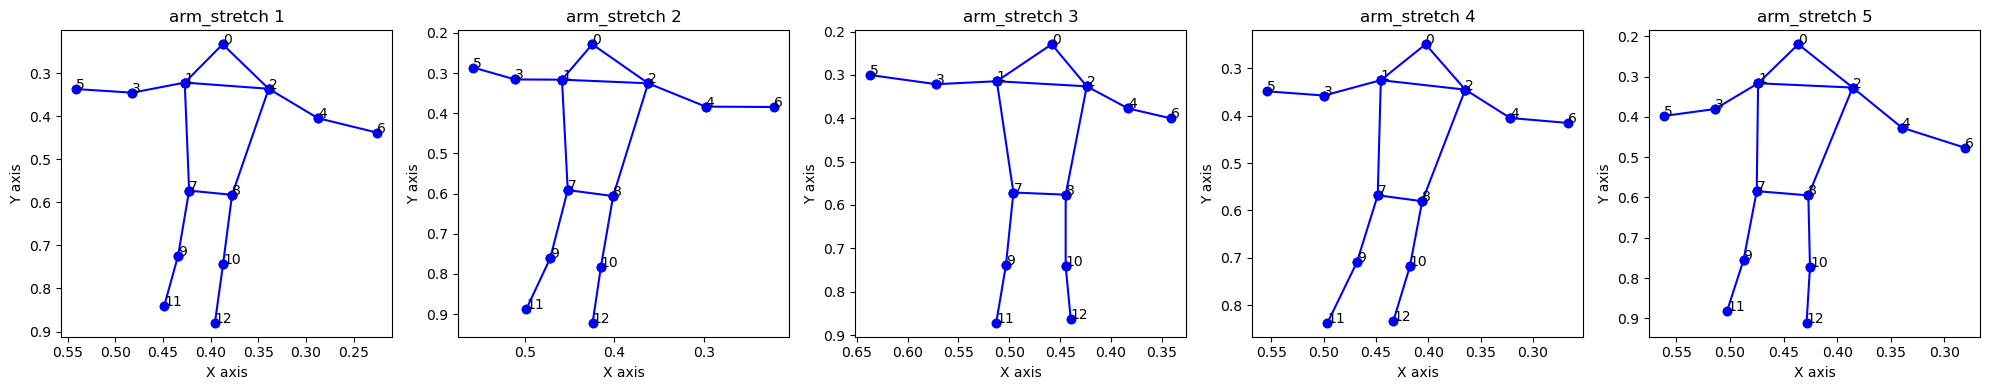

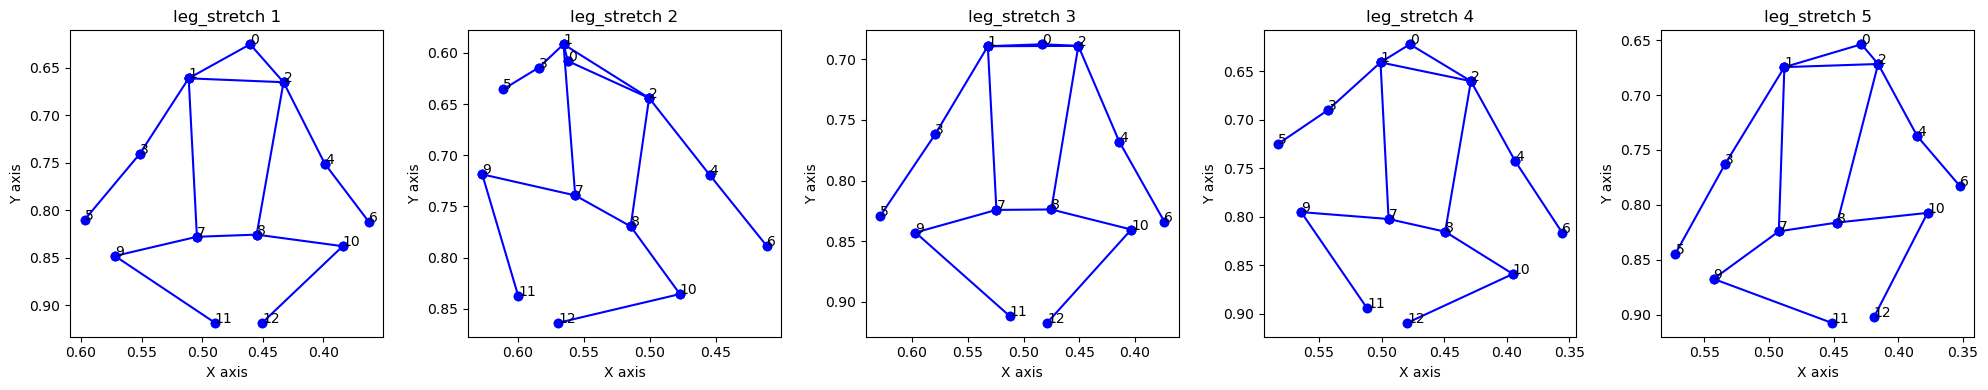

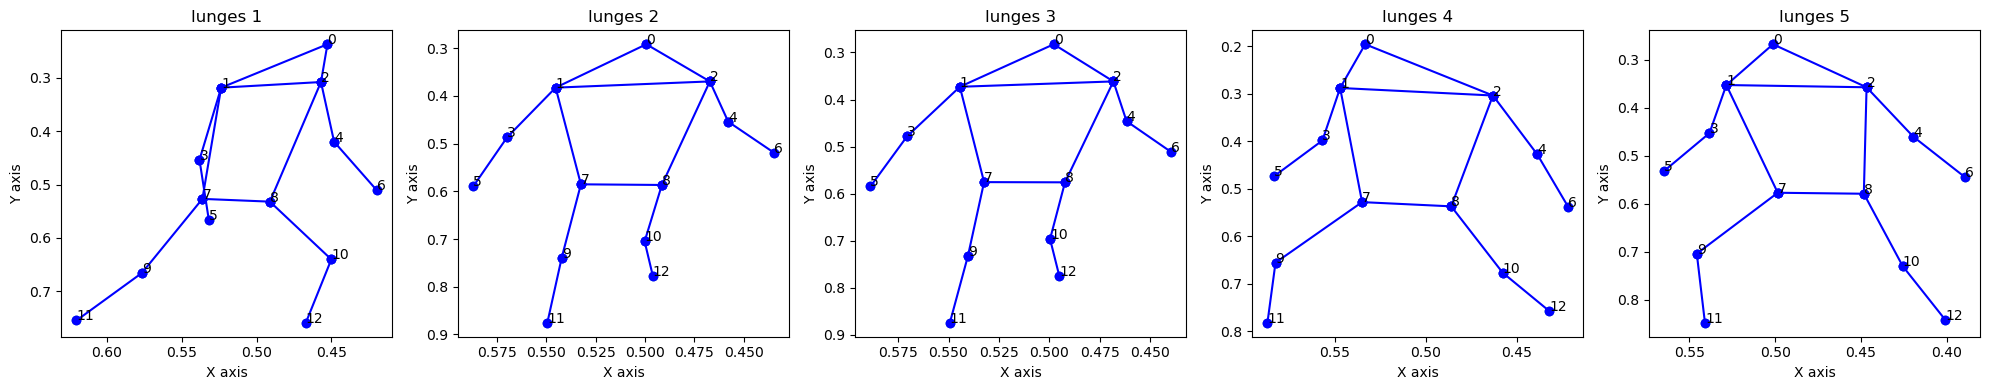

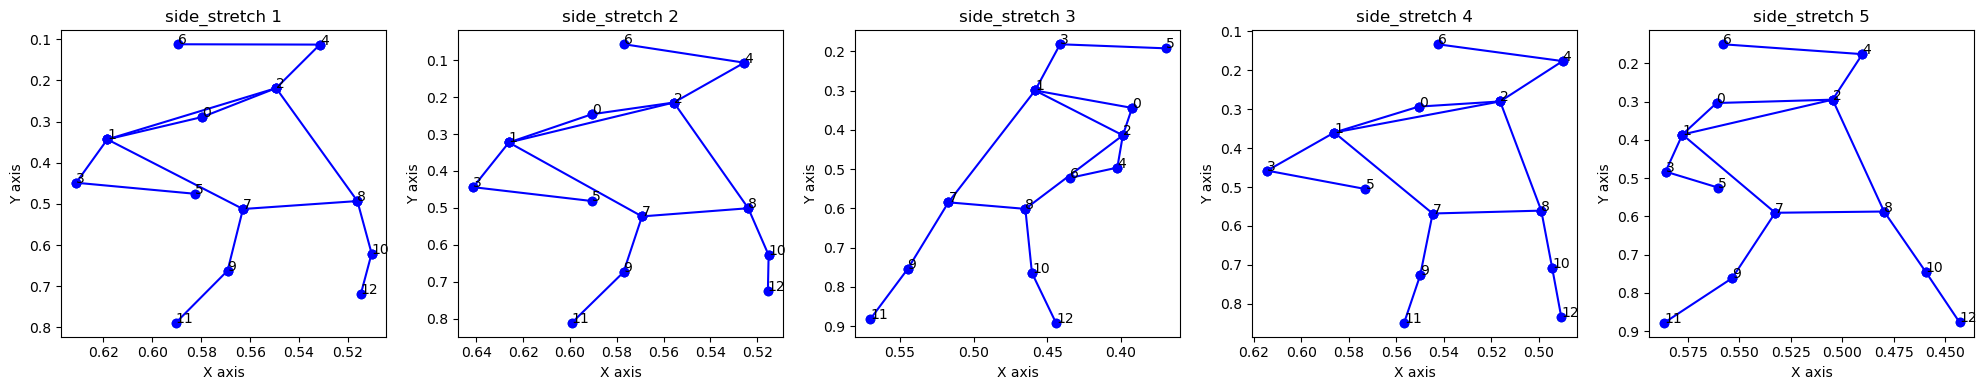

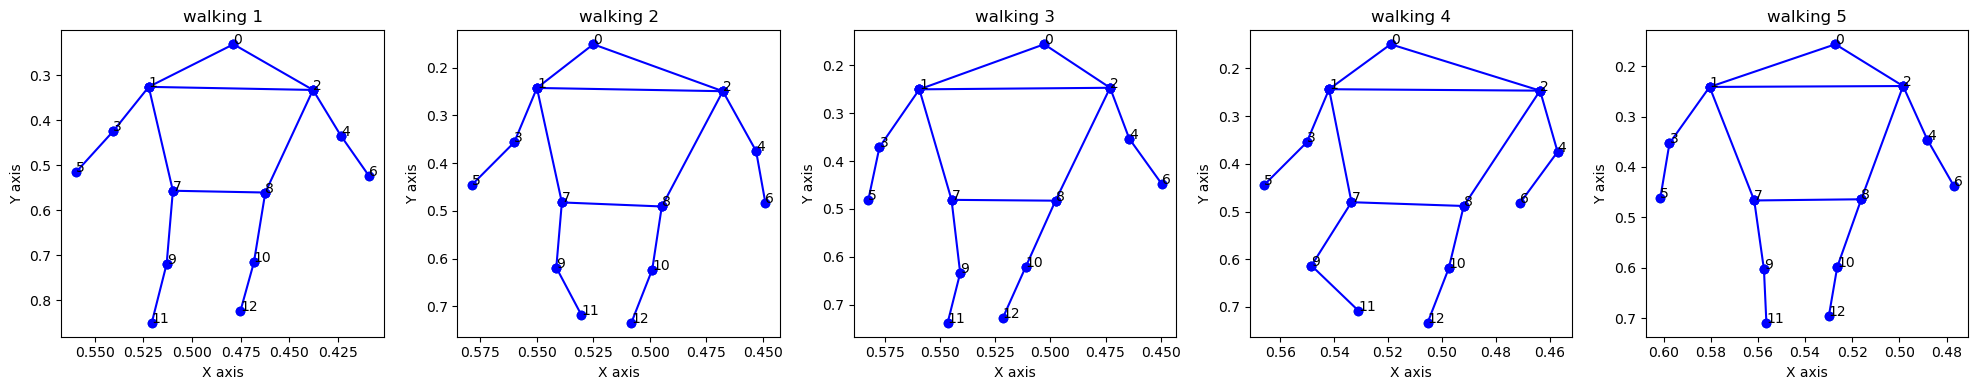

In [21]:
from utils.visualization_utils import visualize_2d_pose_actions_custom

out_poses_2d = np.load("datasets/custom/Processed/test_2d_poses.npy")
out_actions = np.load("datasets/custom/Processed/test_actions.npy")

for action in np.unique(out_actions):
    out_poses_2d_action = out_poses_2d[out_actions == action]
    visualize_2d_pose_actions_custom(out_poses_2d_action, action=action)

Let's visualise the first 2D pose and corresponding 3D poses in the custom dataset

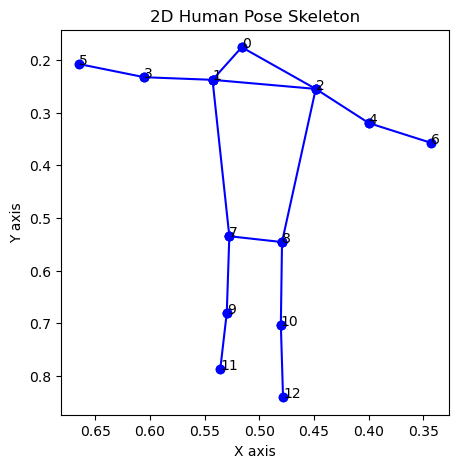

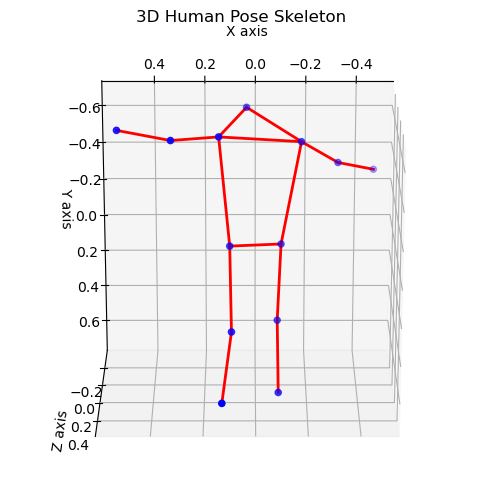

In [22]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose_custom, visualize_3d_pose_custom

poses_2d = np.load("datasets/custom/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/custom/Processed/test_3d_poses.npy")

visualize_2d_pose_custom(poses_2d[0])
visualize_3d_pose_custom(poses_3d[0], elev=110, azim=90)

Let's visualise the distribution of the 5 actions in the custom train and test datasets

actions
arm_stretch     6697
leg_stretch     6563
walking         6416
lunges          6408
side_stretch    6110
Name: count, dtype: int64


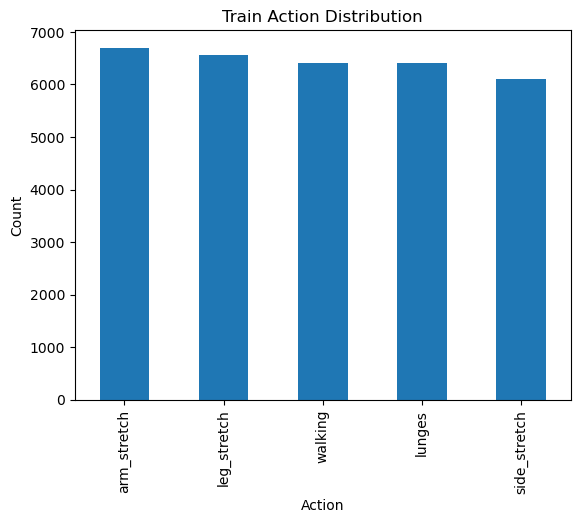

In [23]:
train_actions = np.load("datasets/custom/Processed/train_actions.npy")
show_action_stats(train_actions, "Train")

actions
arm_stretch     480
leg_stretch     480
lunges          480
side_stretch    480
walking         480
Name: count, dtype: int64


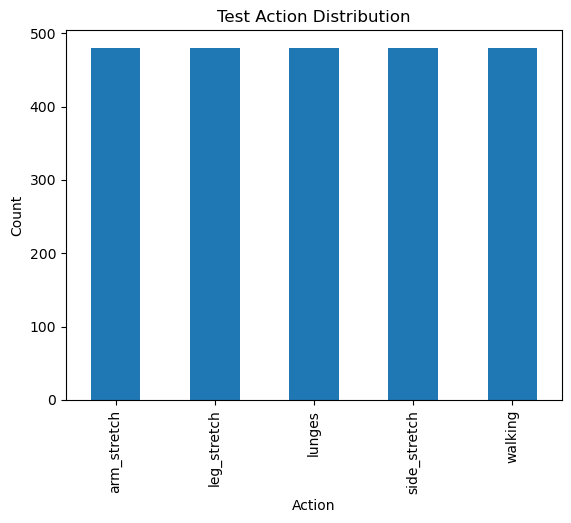

In [24]:
test_actions = np.load("datasets/custom/Processed/test_actions.npy")
show_action_stats(test_actions, "Test")

<h3><u>4.4. Training baseline model (SimplePose)</u></h3>

In [ ]:
from src.simple_pose.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_custom', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', save_path='model_outputs/simple_pose_custom/2024-11-17--09-21-41')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.78it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 158.8680877685547 | Pose Training Loss: 1.5735925436019897 | Action Training Loss: 1.508824110031128 | Action Train Label Accuracy: 37.423122320929366


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 170.78it/s]


Epoch: 0 | Total Testing Loss: 14.504740715026855 | Pose Testing Loss: 0.11845336109399796 | Action Testing Loss: 2.659405469894409 | Action Test Label Accuracy: 20.0
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.39it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 85.60617065429688 | Pose Training Loss: 0.8459522724151611 | Action Training Loss: 1.0109256505966187 | Action Train Label Accuracy: 53.5503509970802


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 185.62it/s]


Epoch: 1 | Total Testing Loss: 14.138185501098633 | Pose Testing Loss: 0.11169858276844025 | Action Testing Loss: 2.968327283859253 | Action Test Label Accuracy: 20.0
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 80.32it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 51.71696090698242 | Pose Training Loss: 0.5086367726325989 | Action Training Loss: 0.8532938361167908 | Action Train Label Accuracy: 60.62309747157856


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 181.18it/s]


Epoch: 2 | Total Testing Loss: 10.414505004882812 | Pose Testing Loss: 0.0768788754940033 | Action Testing Loss: 2.726616382598877 | Action Test Label Accuracy: 20.0
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 78.59it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 33.121376037597656 | Pose Training Loss: 0.3232436776161194 | Action Training Loss: 0.7970070838928223 | Action Train Label Accuracy: 63.59259489345841


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 155.78it/s]


Epoch: 3 | Total Testing Loss: 9.148798942565918 | Pose Testing Loss: 0.06517723202705383 | Action Testing Loss: 2.631075620651245 | Action Test Label Accuracy: 20.0
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.89it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 23.717937469482422 | Pose Training Loss: 0.229532852768898 | Action Training Loss: 0.7646594047546387 | Action Train Label Accuracy: 65.56501211405852


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 185.00it/s]


Epoch: 4 | Total Testing Loss: 8.888945579528809 | Pose Testing Loss: 0.06429732590913773 | Action Testing Loss: 2.459212064743042 | Action Test Label Accuracy: 20.0
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.01it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 18.47554588317871 | Pose Training Loss: 0.17741942405700684 | Action Training Loss: 0.7336008548736572 | Action Train Label Accuracy: 67.7113747903336


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 187.12it/s]


Epoch: 5 | Total Testing Loss: 8.611437797546387 | Pose Testing Loss: 0.06243332847952843 | Action Testing Loss: 2.36810564994812 | Action Test Label Accuracy: 20.25
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.60it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 15.324664115905762 | Pose Training Loss: 0.14620667695999146 | Action Training Loss: 0.7039858102798462 | Action Train Label Accuracy: 69.49431571100206


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 185.02it/s]


Epoch: 6 | Total Testing Loss: 8.223422050476074 | Pose Testing Loss: 0.059359800070524216 | Action Testing Loss: 2.2874419689178467 | Action Test Label Accuracy: 20.375
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 79.70it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 13.264892578125 | Pose Training Loss: 0.12591703236103058 | Action Training Loss: 0.673190176486969 | Action Train Label Accuracy: 71.23066409890042


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 174.85it/s]


Epoch: 7 | Total Testing Loss: 7.842933654785156 | Pose Testing Loss: 0.05481123924255371 | Action Testing Loss: 2.3618102073669434 | Action Test Label Accuracy: 20.583333333333336
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.92it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 11.706273078918457 | Pose Training Loss: 0.11067637801170349 | Action Training Loss: 0.6386374235153198 | Action Train Label Accuracy: 73.11921476051438


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 180.91it/s]


Epoch: 8 | Total Testing Loss: 7.0985260009765625 | Pose Testing Loss: 0.049631137400865555 | Action Testing Loss: 2.1354126930236816 | Action Test Label Accuracy: 23.958333333333336
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.06it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 10.55134105682373 | Pose Training Loss: 0.09941957145929337 | Action Training Loss: 0.6093844771385193 | Action Train Label Accuracy: 74.6039634714543


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 182.28it/s]


Epoch: 9 | Total Testing Loss: 6.8260040283203125 | Pose Testing Loss: 0.04415412247180939 | Action Testing Loss: 2.410592794418335 | Action Test Label Accuracy: 22.958333333333332
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.04it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 9.53645133972168 | Pose Training Loss: 0.08964976668357849 | Action Training Loss: 0.571474552154541 | Action Train Label Accuracy: 76.50493880847364


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 179.40it/s]


Epoch: 10 | Total Testing Loss: 6.227787971496582 | Pose Testing Loss: 0.041821930557489395 | Action Testing Loss: 2.0455944538116455 | Action Test Label Accuracy: 28.625
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 79.81it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 8.759888648986816 | Pose Training Loss: 0.08219175040721893 | Action Training Loss: 0.5407126545906067 | Action Train Label Accuracy: 77.96794433745418


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 176.29it/s]


Epoch: 11 | Total Testing Loss: 6.003182888031006 | Pose Testing Loss: 0.03785937651991844 | Action Testing Loss: 2.217244863510132 | Action Test Label Accuracy: 28.958333333333336
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.17it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 8.07141399383545 | Pose Training Loss: 0.0756165087223053 | Action Training Loss: 0.5097624659538269 | Action Train Label Accuracy: 79.52102876312355


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 182.93it/s]


Epoch: 12 | Total Testing Loss: 5.554859161376953 | Pose Testing Loss: 0.03597448021173477 | Action Testing Loss: 1.9574116468429565 | Action Test Label Accuracy: 32.75
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.48it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 7.509942531585693 | Pose Training Loss: 0.07024296373128891 | Action Training Loss: 0.485645592212677 | Action Train Label Accuracy: 80.6858420823756


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 181.65it/s]


Epoch: 13 | Total Testing Loss: 5.195000171661377 | Pose Testing Loss: 0.03368651866912842 | Action Testing Loss: 1.8263483047485352 | Action Test Label Accuracy: 35.625
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 75.69it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 6.99613094329834 | Pose Training Loss: 0.06542618572711945 | Action Training Loss: 0.45351463556289673 | Action Train Label Accuracy: 82.09293657203206


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 183.39it/s]


Epoch: 14 | Total Testing Loss: 4.95660924911499 | Pose Testing Loss: 0.03133685514330864 | Action Testing Loss: 1.8229230642318726 | Action Test Label Accuracy: 36.333333333333336
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 79.37it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 6.569628715515137 | Pose Training Loss: 0.06140951067209244 | Action Training Loss: 0.4286794662475586 | Action Train Label Accuracy: 82.97198235696092


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 181.27it/s]


Epoch: 15 | Total Testing Loss: 4.884727954864502 | Pose Testing Loss: 0.030209971591830254 | Action Testing Loss: 1.863730788230896 | Action Test Label Accuracy: 35.875
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.10it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 6.162843704223633 | Pose Training Loss: 0.05753231421113014 | Action Training Loss: 0.4096134901046753 | Action Train Label Accuracy: 84.10573398769957


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 180.64it/s]


Epoch: 16 | Total Testing Loss: 4.811641693115234 | Pose Testing Loss: 0.028288954868912697 | Action Testing Loss: 1.9827461242675781 | Action Test Label Accuracy: 37.708333333333336
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 80.76it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 5.814176559448242 | Pose Training Loss: 0.054272864013910294 | Action Training Loss: 0.38688933849334717 | Action Train Label Accuracy: 84.96924892837174


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 184.35it/s]


Epoch: 17 | Total Testing Loss: 4.564406871795654 | Pose Testing Loss: 0.02728303335607052 | Action Testing Loss: 1.8361027240753174 | Action Test Label Accuracy: 38.79166666666667
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.65it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 5.505810260772705 | Pose Training Loss: 0.05138162150979042 | Action Training Loss: 0.3676486611366272 | Action Train Label Accuracy: 85.94769211654345


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 174.50it/s]


Epoch: 18 | Total Testing Loss: 4.392388820648193 | Pose Testing Loss: 0.026375798508524895 | Action Testing Loss: 1.754809021949768 | Action Test Label Accuracy: 38.958333333333336
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 80.67it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 5.2156829833984375 | Pose Training Loss: 0.048666082322597504 | Action Training Loss: 0.34907588362693787 | Action Train Label Accuracy: 86.65589861464869


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 187.69it/s]


Epoch: 19 | Total Testing Loss: 4.5503435134887695 | Pose Testing Loss: 0.025700030848383904 | Action Testing Loss: 1.9803400039672852 | Action Test Label Accuracy: 38.79166666666667
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.14it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 4.971051216125488 | Pose Training Loss: 0.046408891677856445 | Action Training Loss: 0.3301609456539154 | Action Train Label Accuracy: 87.66229732248246


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 177.37it/s]


Epoch: 20 | Total Testing Loss: 4.411677837371826 | Pose Testing Loss: 0.025155356153845787 | Action Testing Loss: 1.8961416482925415 | Action Test Label Accuracy: 39.04166666666667
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.49it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 4.743142604827881 | Pose Training Loss: 0.044319503009319305 | Action Training Loss: 0.3111892342567444 | Action Train Label Accuracy: 88.40777784680375


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 168.20it/s]


Epoch: 21 | Total Testing Loss: 4.291747570037842 | Pose Testing Loss: 0.02463706210255623 | Action Testing Loss: 1.828041911125183 | Action Test Label Accuracy: 39.54166666666667
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 80.86it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 4.552125453948975 | Pose Training Loss: 0.04254040867090225 | Action Training Loss: 0.29808229207992554 | Action Train Label Accuracy: 88.74945642045101


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 179.26it/s]


Epoch: 22 | Total Testing Loss: 3.993650197982788 | Pose Testing Loss: 0.02461198717355728 | Action Testing Loss: 1.5324517488479614 | Action Test Label Accuracy: 40.958333333333336
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 79.89it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 4.3711652755737305 | Pose Training Loss: 0.04089689254760742 | Action Training Loss: 0.28147682547569275 | Action Train Label Accuracy: 89.70926259551469


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 175.08it/s]


Epoch: 23 | Total Testing Loss: 4.097865581512451 | Pose Testing Loss: 0.024369308724999428 | Action Testing Loss: 1.6609344482421875 | Action Test Label Accuracy: 40.583333333333336
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 70.66it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 4.194711208343506 | Pose Training Loss: 0.03932053968310356 | Action Training Loss: 0.26265838742256165 | Action Train Label Accuracy: 90.43610610672796


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 177.67it/s]


Epoch: 24 | Total Testing Loss: 3.9985299110412598 | Pose Testing Loss: 0.02429943159222603 | Action Testing Loss: 1.5685865879058838 | Action Test Label Accuracy: 41.833333333333336
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.50it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 4.053676128387451 | Pose Training Loss: 0.038035012781620026 | Action Training Loss: 0.2501749098300934 | Action Train Label Accuracy: 91.25924085233274


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 178.33it/s]


Epoch: 25 | Total Testing Loss: 4.023375034332275 | Pose Testing Loss: 0.02408008463680744 | Action Testing Loss: 1.6153665781021118 | Action Test Label Accuracy: 41.583333333333336
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 80.77it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 3.8960278034210205 | Pose Training Loss: 0.0366131030023098 | Action Training Loss: 0.23471814393997192 | Action Train Label Accuracy: 91.78107721935764


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 178.94it/s]


Epoch: 26 | Total Testing Loss: 4.13593053817749 | Pose Testing Loss: 0.023670418187975883 | Action Testing Loss: 1.768889307975769 | Action Test Label Accuracy: 45.125
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.02it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 3.7766196727752686 | Pose Training Loss: 0.03554868325591087 | Action Training Loss: 0.22175225615501404 | Action Train Label Accuracy: 92.54830092563832


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 178.26it/s]


Epoch: 27 | Total Testing Loss: 3.8994667530059814 | Pose Testing Loss: 0.02349700592458248 | Action Testing Loss: 1.549765944480896 | Action Test Label Accuracy: 48.95833333333333
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.19it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 3.6671485900878906 | Pose Training Loss: 0.03457837924361229 | Action Training Loss: 0.20931008458137512 | Action Train Label Accuracy: 92.83717462881282


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 185.23it/s]


Epoch: 28 | Total Testing Loss: 3.9393727779388428 | Pose Testing Loss: 0.022818228229880333 | Action Testing Loss: 1.6575498580932617 | Action Test Label Accuracy: 50.875
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 81.09it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 3.5527873039245605 | Pose Training Loss: 0.03356274217367172 | Action Training Loss: 0.19651304185390472 | Action Train Label Accuracy: 93.42734671056718


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 177.21it/s]


Epoch: 29 | Total Testing Loss: 3.8463234901428223 | Pose Testing Loss: 0.02288799360394478 | Action Testing Loss: 1.55752432346344 | Action Test Label Accuracy: 56.208333333333336


<Figure size 640x480 with 0 Axes>

<h3><u>4.5. Training Graph Convolutional model (SimplePoseGNN)</u></h3>

In [ ]:
from src.simple_pose_gnn.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gnn_custom', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', save_path='model_outputs/simple_pose_gnn_custom/2024-11-17--08-39-44')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:22<00:00,  5.63it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 37.714317321777344 | Pose Training Loss: 0.36073991656303406 | Action Training Loss: 1.6403099298477173 | Action Train Label Accuracy: 21.74007579051997


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


Epoch: 0 | Total Testing Loss: 6.000362396240234 | Pose Testing Loss: 0.0446021631360054 | Action Testing Loss: 1.5401461124420166 | Action Test Label Accuracy: 33.625
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.16it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 17.883731842041016 | Pose Training Loss: 0.1632789820432663 | Action Training Loss: 1.555834174156189 | Action Train Label Accuracy: 28.452506678263028


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Epoch: 1 | Total Testing Loss: 5.342889308929443 | Pose Testing Loss: 0.039038948714733124 | Action Testing Loss: 1.4389941692352295 | Action Test Label Accuracy: 45.916666666666664
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.17it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 11.371230125427246 | Pose Training Loss: 0.09922848641872406 | Action Training Loss: 1.448385238647461 | Action Train Label Accuracy: 36.56892588681121


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Epoch: 2 | Total Testing Loss: 5.204286098480225 | Pose Testing Loss: 0.03892947733402252 | Action Testing Loss: 1.3113385438919067 | Action Test Label Accuracy: 55.791666666666664
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.08it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 8.630080223083496 | Pose Training Loss: 0.07303892076015472 | Action Training Loss: 1.3261865377426147 | Action Train Label Accuracy: 41.80592657016835


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Epoch: 3 | Total Testing Loss: 4.888587474822998 | Pose Testing Loss: 0.036871712654829025 | Action Testing Loss: 1.201416015625 | Action Test Label Accuracy: 64.75
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.10it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 7.3558244705200195 | Pose Training Loss: 0.06132775545120239 | Action Training Loss: 1.2230476140975952 | Action Train Label Accuracy: 45.53022302292353


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


Epoch: 4 | Total Testing Loss: 4.532105922698975 | Pose Testing Loss: 0.03412986919283867 | Action Testing Loss: 1.1191195249557495 | Action Test Label Accuracy: 67.79166666666666
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.06it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 6.642796993255615 | Pose Training Loss: 0.0549495667219162 | Action Training Loss: 1.1478407382965088 | Action Train Label Accuracy: 48.72336460209977


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch: 5 | Total Testing Loss: 4.269049167633057 | Pose Testing Loss: 0.032060977071523666 | Action Testing Loss: 1.062951922416687 | Action Test Label Accuracy: 63.041666666666664
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.14it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 6.185048580169678 | Pose Training Loss: 0.05094769224524498 | Action Training Loss: 1.0902814865112305 | Action Train Label Accuracy: 51.58103994533143


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


Epoch: 6 | Total Testing Loss: 4.038477897644043 | Pose Testing Loss: 0.030037248507142067 | Action Testing Loss: 1.0347527265548706 | Action Test Label Accuracy: 61.5
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.06it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 5.834321022033691 | Pose Training Loss: 0.04794291406869888 | Action Training Loss: 1.0400302410125732 | Action Train Label Accuracy: 54.152947754239925


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 7 | Total Testing Loss: 3.8277223110198975 | Pose Testing Loss: 0.028386685997247696 | Action Testing Loss: 0.9890533685684204 | Action Test Label Accuracy: 61.66666666666667
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.85it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 5.545805931091309 | Pose Training Loss: 0.045611605048179626 | Action Training Loss: 0.9846470952033997 | Action Train Label Accuracy: 57.37093868422688


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Epoch: 8 | Total Testing Loss: 3.631406784057617 | Pose Testing Loss: 0.0268689151853323 | Action Testing Loss: 0.9445155262947083 | Action Test Label Accuracy: 62.875
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  6.00it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 5.293685436248779 | Pose Training Loss: 0.04362371936440468 | Action Training Loss: 0.9313135743141174 | Action Train Label Accuracy: 59.22221531962477


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Epoch: 9 | Total Testing Loss: 3.465406894683838 | Pose Testing Loss: 0.025635093450546265 | Action Testing Loss: 0.9018974304199219 | Action Test Label Accuracy: 64.75
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.16it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 5.0606184005737305 | Pose Training Loss: 0.04182446375489235 | Action Training Loss: 0.8781706690788269 | Action Train Label Accuracy: 60.99583773373921


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Epoch: 10 | Total Testing Loss: 3.2644011974334717 | Pose Testing Loss: 0.024171508848667145 | Action Testing Loss: 0.8472504019737244 | Action Test Label Accuracy: 68.29166666666666
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.15it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 4.8437628746032715 | Pose Training Loss: 0.04015728086233139 | Action Training Loss: 0.828034520149231 | Action Train Label Accuracy: 62.68869975771882


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


Epoch: 11 | Total Testing Loss: 3.0832836627960205 | Pose Testing Loss: 0.022888971492648125 | Action Testing Loss: 0.7943863272666931 | Action Test Label Accuracy: 70.16666666666667
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.18it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 4.650606632232666 | Pose Training Loss: 0.03872573748230934 | Action Training Loss: 0.7780320644378662 | Action Train Label Accuracy: 64.38777411940113


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Epoch: 12 | Total Testing Loss: 2.903841972351074 | Pose Testing Loss: 0.0215502567589283 | Action Testing Loss: 0.7488164305686951 | Action Test Label Accuracy: 72.08333333333333
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.93it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 4.482811450958252 | Pose Training Loss: 0.037466861307621 | Action Training Loss: 0.7361244559288025 | Action Train Label Accuracy: 65.77001925824688


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


Epoch: 13 | Total Testing Loss: 2.7984635829925537 | Pose Testing Loss: 0.02085983008146286 | Action Testing Loss: 0.7124808430671692 | Action Test Label Accuracy: 72.29166666666667
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.88it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 4.319504737854004 | Pose Training Loss: 0.0361844077706337 | Action Training Loss: 0.7010629773139954 | Action Train Label Accuracy: 66.68012673168914


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Epoch: 14 | Total Testing Loss: 2.6182780265808105 | Pose Testing Loss: 0.019453896209597588 | Action Testing Loss: 0.672888457775116 | Action Test Label Accuracy: 73.91666666666666
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.94it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 4.178109645843506 | Pose Training Loss: 0.035056356340646744 | Action Training Loss: 0.6724737286567688 | Action Train Label Accuracy: 67.66788842641486


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 15 | Total Testing Loss: 2.4883105754852295 | Pose Testing Loss: 0.018665360286831856 | Action Testing Loss: 0.6217744946479797 | Action Test Label Accuracy: 76.0
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.98it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 4.038969039916992 | Pose Training Loss: 0.03391425311565399 | Action Training Loss: 0.6475448608398438 | Action Train Label Accuracy: 68.63080077032988


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Epoch: 16 | Total Testing Loss: 2.3985111713409424 | Pose Testing Loss: 0.017758965492248535 | Action Testing Loss: 0.6226145625114441 | Action Test Label Accuracy: 73.83333333333333
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.10it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 3.9154207706451416 | Pose Training Loss: 0.032892126590013504 | Action Training Loss: 0.6262086033821106 | Action Train Label Accuracy: 69.35764428154314


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 17 | Total Testing Loss: 2.2276904582977295 | Pose Testing Loss: 0.01650703139603138 | Action Testing Loss: 0.5769872069358826 | Action Test Label Accuracy: 77.41666666666667
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.91it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 3.7965006828308105 | Pose Training Loss: 0.03186830133199692 | Action Training Loss: 0.6096699833869934 | Action Train Label Accuracy: 69.87326831086537


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


Epoch: 18 | Total Testing Loss: 2.0996041297912598 | Pose Testing Loss: 0.015541605651378632 | Action Testing Loss: 0.5454434752464294 | Action Test Label Accuracy: 77.91666666666667
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.92it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 3.678908586502075 | Pose Training Loss: 0.030897410586476326 | Action Training Loss: 0.5891678929328918 | Action Train Label Accuracy: 70.9169410449152


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 19 | Total Testing Loss: 1.9624990224838257 | Pose Testing Loss: 0.014344505965709686 | Action Testing Loss: 0.5280483961105347 | Action Test Label Accuracy: 78.625
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.16it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 3.5707449913024902 | Pose Training Loss: 0.0299838799983263 | Action Training Loss: 0.5723558664321899 | Action Train Label Accuracy: 72.0475865068025


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch: 20 | Total Testing Loss: 1.8845933675765991 | Pose Testing Loss: 0.01369071938097477 | Action Testing Loss: 0.5155217051506042 | Action Test Label Accuracy: 79.08333333333334
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.84it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 3.4543957710266113 | Pose Training Loss: 0.029015757143497467 | Action Training Loss: 0.5528197884559631 | Action Train Label Accuracy: 73.42051313909424


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Epoch: 21 | Total Testing Loss: 1.7582670450210571 | Pose Testing Loss: 0.01272787619382143 | Action Testing Loss: 0.4854795038700104 | Action Test Label Accuracy: 81.20833333333334
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.91it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 3.352302074432373 | Pose Training Loss: 0.02816575951874256 | Action Training Loss: 0.5357258915901184 | Action Train Label Accuracy: 74.80897061564266


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 22 | Total Testing Loss: 1.6530998945236206 | Pose Testing Loss: 0.01198518555611372 | Action Testing Loss: 0.45458149909973145 | Action Test Label Accuracy: 85.70833333333333
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.99it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 3.244232416152954 | Pose Training Loss: 0.027304669842123985 | Action Training Loss: 0.5137646794319153 | Action Train Label Accuracy: 76.80313101820215


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch: 23 | Total Testing Loss: 1.56304132938385 | Pose Testing Loss: 0.011284707114100456 | Action Testing Loss: 0.43457069993019104 | Action Test Label Accuracy: 84.625
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.95it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 3.143807888031006 | Pose Training Loss: 0.026554804295301437 | Action Training Loss: 0.48832690715789795 | Action Train Label Accuracy: 78.36553395042554


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch: 24 | Total Testing Loss: 1.4566868543624878 | Pose Testing Loss: 0.010593350976705551 | Action Testing Loss: 0.39735159277915955 | Action Test Label Accuracy: 88.70833333333333
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.93it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 3.0398330688476562 | Pose Training Loss: 0.025769824162125587 | Action Training Loss: 0.46284911036491394 | Action Train Label Accuracy: 79.965210908865


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Epoch: 25 | Total Testing Loss: 1.41031014919281 | Pose Testing Loss: 0.010293652303516865 | Action Testing Loss: 0.3809449374675751 | Action Test Label Accuracy: 86.79166666666667
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.79it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 2.9510278701782227 | Pose Training Loss: 0.02514844387769699 | Action Training Loss: 0.4361836910247803 | Action Train Label Accuracy: 81.85686773933031


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch: 26 | Total Testing Loss: 1.3308981657028198 | Pose Testing Loss: 0.009875102899968624 | Action Testing Loss: 0.3433879017829895 | Action Test Label Accuracy: 89.95833333333333
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:20<00:00,  6.10it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 2.865375280380249 | Pose Training Loss: 0.024542605504393578 | Action Training Loss: 0.4111143946647644 | Action Train Label Accuracy: 83.25153755358141


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 27 | Total Testing Loss: 1.2284334897994995 | Pose Testing Loss: 0.009261858649551868 | Action Testing Loss: 0.3022475838661194 | Action Test Label Accuracy: 92.45833333333333
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:19<00:00,  6.31it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 2.7746057510375977 | Pose Training Loss: 0.023917444050312042 | Action Training Loss: 0.38286271691322327 | Action Train Label Accuracy: 84.87606386283159


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 28 | Total Testing Loss: 1.159064769744873 | Pose Testing Loss: 0.008857653476297855 | Action Testing Loss: 0.2732994258403778 | Action Test Label Accuracy: 94.20833333333334
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:21<00:00,  5.85it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 2.6875386238098145 | Pose Training Loss: 0.02336752787232399 | Action Training Loss: 0.35078567266464233 | Action Train Label Accuracy: 86.81120705721564


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 29 | Total Testing Loss: 1.0730615854263306 | Pose Testing Loss: 0.00841727014631033 | Action Testing Loss: 0.23133455216884613 | Action Test Label Accuracy: 95.75


<Figure size 640x480 with 0 Axes>

<h3><u>4.6. Training Graph Transformer model (SimplePoseGAT)</u></h3>

In [ ]:
from src.simple_pose_gat.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat_custom', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', save_path='model_outputs/simple_pose_gat_custom/2024-11-17--09-05-38')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.29it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 18.847429275512695 | Pose Training Loss: 0.1733040064573288 | Action Training Loss: 1.5170223712921143 | Action Train Label Accuracy: 27.290799527862337


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Epoch: 0 | Total Testing Loss: 4.888330936431885 | Pose Testing Loss: 0.03508218750357628 | Action Testing Loss: 1.3801120519638062 | Action Test Label Accuracy: 34.708333333333336
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 6.682464599609375 | Pose Training Loss: 0.05359276384115219 | Action Training Loss: 1.3231863975524902 | Action Train Label Accuracy: 39.17189538423308


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 1 | Total Testing Loss: 3.4098281860351562 | Pose Testing Loss: 0.021639913320541382 | Action Testing Loss: 1.2458367347717285 | Action Test Label Accuracy: 47.5
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.24it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 4.770929336547852 | Pose Training Loss: 0.03551367670297623 | Action Training Loss: 1.2195608615875244 | Action Train Label Accuracy: 46.654656147108156


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 2 | Total Testing Loss: 2.760838747024536 | Pose Testing Loss: 0.01593446172773838 | Action Testing Loss: 1.167392373085022 | Action Test Label Accuracy: 54.91666666666667
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.12it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 3.7399611473083496 | Pose Training Loss: 0.025832826271653175 | Action Training Loss: 1.1566786766052246 | Action Train Label Accuracy: 50.58706591290303


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Epoch: 3 | Total Testing Loss: 2.360884428024292 | Pose Testing Loss: 0.012459858320653439 | Action Testing Loss: 1.114898681640625 | Action Test Label Accuracy: 57.91666666666667
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.26it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 3.0791923999786377 | Pose Training Loss: 0.019740356132388115 | Action Training Loss: 1.1051560640335083 | Action Train Label Accuracy: 52.80797664161023


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch: 4 | Total Testing Loss: 2.096870183944702 | Pose Testing Loss: 0.010267323814332485 | Action Testing Loss: 1.0701379776000977 | Action Test Label Accuracy: 61.75000000000001
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.42it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 2.638282537460327 | Pose Training Loss: 0.015783263370394707 | Action Training Loss: 1.059957504272461 | Action Train Label Accuracy: 56.0508169224079


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch: 5 | Total Testing Loss: 1.8768690824508667 | Pose Testing Loss: 0.008604113012552261 | Action Testing Loss: 1.0164577960968018 | Action Test Label Accuracy: 66.45833333333333
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.24it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 2.3209707736968994 | Pose Training Loss: 0.013055916875600815 | Action Training Loss: 1.0153781175613403 | Action Train Label Accuracy: 59.38684226874573


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Epoch: 6 | Total Testing Loss: 1.7197178602218628 | Pose Testing Loss: 0.0074919359758496284 | Action Testing Loss: 0.97052401304245 | Action Test Label Accuracy: 67.70833333333334
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:27<00:00,  4.55it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 2.0781779289245605 | Pose Training Loss: 0.011137526482343674 | Action Training Loss: 0.9644256234169006 | Action Train Label Accuracy: 62.62347021184071


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


Epoch: 7 | Total Testing Loss: 1.5931633710861206 | Pose Testing Loss: 0.00678751477971673 | Action Testing Loss: 0.9144118428230286 | Action Test Label Accuracy: 70.91666666666666
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.42it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 1.8765244483947754 | Pose Training Loss: 0.009722626768052578 | Action Training Loss: 0.9042615294456482 | Action Train Label Accuracy: 66.5496676399329


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch: 8 | Total Testing Loss: 1.4656723737716675 | Pose Testing Loss: 0.006207507103681564 | Action Testing Loss: 0.8449217081069946 | Action Test Label Accuracy: 74.125
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.15it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 1.7060773372650146 | Pose Training Loss: 0.008699155412614346 | Action Training Loss: 0.8361616134643555 | Action Train Label Accuracy: 70.44790954836306


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch: 9 | Total Testing Loss: 1.3457680940628052 | Pose Testing Loss: 0.00577841280028224 | Action Testing Loss: 0.7679266929626465 | Action Test Label Accuracy: 78.625
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.37it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 1.5461571216583252 | Pose Training Loss: 0.007890376262366772 | Action Training Loss: 0.757119357585907 | Action Train Label Accuracy: 74.4579735354414


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch: 10 | Total Testing Loss: 1.2230852842330933 | Pose Testing Loss: 0.0054253279231488705 | Action Testing Loss: 0.6805524230003357 | Action Test Label Accuracy: 81.16666666666667
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.35it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 1.4028596878051758 | Pose Training Loss: 0.007275119889527559 | Action Training Loss: 0.6753474473953247 | Action Train Label Accuracy: 77.67907063427968


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 11 | Total Testing Loss: 1.0962234735488892 | Pose Testing Loss: 0.0051146079786121845 | Action Testing Loss: 0.584762692451477 | Action Test Label Accuracy: 83.08333333333333
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.31it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 1.2704097032546997 | Pose Training Loss: 0.006765310186892748 | Action Training Loss: 0.5938781499862671 | Action Train Label Accuracy: 79.94657389575698


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Epoch: 12 | Total Testing Loss: 0.9957235455513 | Pose Testing Loss: 0.004873571451753378 | Action Testing Loss: 0.5083664059638977 | Action Test Label Accuracy: 85.0
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:27<00:00,  4.50it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 1.1567158699035645 | Pose Training Loss: 0.006326667033135891 | Action Training Loss: 0.5240492224693298 | Action Train Label Accuracy: 82.08672423432938


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch: 13 | Total Testing Loss: 0.9096500277519226 | Pose Testing Loss: 0.004686473403126001 | Action Testing Loss: 0.4410026967525482 | Action Test Label Accuracy: 84.875
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.29it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 1.0652787685394287 | Pose Training Loss: 0.005972470156848431 | Action Training Loss: 0.4680315852165222 | Action Train Label Accuracy: 83.4099521649997


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


Epoch: 14 | Total Testing Loss: 0.8358082175254822 | Pose Testing Loss: 0.004498257301747799 | Action Testing Loss: 0.385982483625412 | Action Test Label Accuracy: 86.5
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.26it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 0.9818954467773438 | Pose Training Loss: 0.005638862960040569 | Action Training Loss: 0.4180089235305786 | Action Train Label Accuracy: 85.29850282661366


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch: 15 | Total Testing Loss: 0.7859076261520386 | Pose Testing Loss: 0.0043704756535589695 | Action Testing Loss: 0.3488600552082062 | Action Test Label Accuracy: 88.75
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 0.9134091138839722 | Pose Training Loss: 0.0053558070212602615 | Action Training Loss: 0.37782803177833557 | Action Train Label Accuracy: 87.24607069640305


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Epoch: 16 | Total Testing Loss: 0.7367722392082214 | Pose Testing Loss: 0.004249818157404661 | Action Testing Loss: 0.31179043650627136 | Action Test Label Accuracy: 91.95833333333333
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.26it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 0.8466176986694336 | Pose Training Loss: 0.005099284928292036 | Action Training Loss: 0.336689293384552 | Action Train Label Accuracy: 89.73721811517674


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch: 17 | Total Testing Loss: 0.6659722328186035 | Pose Testing Loss: 0.004074958618730307 | Action Testing Loss: 0.2584763765335083 | Action Test Label Accuracy: 95.54166666666667
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.41it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 0.789129912853241 | Pose Training Loss: 0.004906782880425453 | Action Training Loss: 0.29845139384269714 | Action Train Label Accuracy: 91.63819345219606


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Epoch: 18 | Total Testing Loss: 0.6178909540176392 | Pose Testing Loss: 0.003949982579797506 | Action Testing Loss: 0.2228926718235016 | Action Test Label Accuracy: 96.29166666666666
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.12it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 0.7367039918899536 | Pose Training Loss: 0.004732431378215551 | Action Training Loss: 0.26346060633659363 | Action Train Label Accuracy: 93.0515002795552


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Epoch: 19 | Total Testing Loss: 0.5750098824501038 | Pose Testing Loss: 0.0038906403351575136 | Action Testing Loss: 0.18594585359096527 | Action Test Label Accuracy: 97.375
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:27<00:00,  4.50it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 0.6820797920227051 | Pose Training Loss: 0.004557604435831308 | Action Training Loss: 0.2263195663690567 | Action Train Label Accuracy: 94.13555320867243


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Epoch: 20 | Total Testing Loss: 0.5367264151573181 | Pose Testing Loss: 0.0038602936547249556 | Action Testing Loss: 0.1506970375776291 | Action Test Label Accuracy: 97.79166666666667
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.12it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 0.6342492699623108 | Pose Training Loss: 0.004400122910737991 | Action Training Loss: 0.19423680007457733 | Action Train Label Accuracy: 95.14195191650619


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch: 21 | Total Testing Loss: 0.5014554858207703 | Pose Testing Loss: 0.003690306795760989 | Action Testing Loss: 0.13242487609386444 | Action Test Label Accuracy: 97.5
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.32it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 0.5954297184944153 | Pose Training Loss: 0.004255352541804314 | Action Training Loss: 0.1698944866657257 | Action Train Label Accuracy: 95.69174380319313


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 22 | Total Testing Loss: 0.46493569016456604 | Pose Testing Loss: 0.003570642787963152 | Action Testing Loss: 0.10787143558263779 | Action Test Label Accuracy: 98.08333333333333
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.20it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 0.5630213618278503 | Pose Training Loss: 0.00412291893735528 | Action Training Loss: 0.1507297307252884 | Action Train Label Accuracy: 96.0334223768404


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch: 23 | Total Testing Loss: 0.44215860962867737 | Pose Testing Loss: 0.00349289714358747 | Action Testing Loss: 0.09286892414093018 | Action Test Label Accuracy: 98.16666666666667
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.25it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 0.5287870168685913 | Pose Training Loss: 0.003990016411989927 | Action Training Loss: 0.12978529930114746 | Action Train Label Accuracy: 96.63291296514879


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch: 24 | Total Testing Loss: 0.42629334330558777 | Pose Testing Loss: 0.0034683928824961185 | Action Testing Loss: 0.07945401221513748 | Action Test Label Accuracy: 98.16666666666667
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:29<00:00,  4.29it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 0.5113875269889832 | Pose Training Loss: 0.0038873443845659494 | Action Training Loss: 0.1226532980799675 | Action Train Label Accuracy: 96.71056718643226


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Epoch: 25 | Total Testing Loss: 0.3950822949409485 | Pose Testing Loss: 0.003281459677964449 | Action Testing Loss: 0.06693637371063232 | Action Test Label Accuracy: 98.875
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 0.4857252836227417 | Pose Training Loss: 0.003774957964196801 | Action Training Loss: 0.10822926461696625 | Action Train Label Accuracy: 97.13611231906566


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Epoch: 26 | Total Testing Loss: 0.3784596025943756 | Pose Testing Loss: 0.003200934501364827 | Action Testing Loss: 0.05836616829037666 | Action Test Label Accuracy: 99.33333333333333
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:30<00:00,  4.11it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 0.4692411422729492 | Pose Training Loss: 0.003682614304125309 | Action Training Loss: 0.100979745388031 | Action Train Label Accuracy: 97.09883829284959


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch: 27 | Total Testing Loss: 0.3716006577014923 | Pose Testing Loss: 0.0031931009143590927 | Action Testing Loss: 0.05229054018855095 | Action Test Label Accuracy: 99.41666666666666
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:28<00:00,  4.36it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 0.4505458474159241 | Pose Training Loss: 0.0035965824499726295 | Action Training Loss: 0.09088759124279022 | Action Train Label Accuracy: 97.3721811517674


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch: 28 | Total Testing Loss: 0.3583279848098755 | Pose Testing Loss: 0.0031420474406331778 | Action Testing Loss: 0.044123243540525436 | Action Test Label Accuracy: 99.5
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 0.4308996796607971 | Pose Training Loss: 0.003506248816847801 | Action Training Loss: 0.08027482032775879 | Action Train Label Accuracy: 97.85053115487358


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


Epoch: 29 | Total Testing Loss: 0.3450351655483246 | Pose Testing Loss: 0.00305281113833189 | Action Testing Loss: 0.03975405916571617 | Action Test Label Accuracy: 99.5


<Figure size 640x480 with 0 Axes>

<h3><u>4.7. Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG)</u></h3>

In [ ]:
from src.simple_pose_tag.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 1,
    'pose_loss_multiplier': 100,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_tag_custom', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

Training args are: Namespace(learning_rate=3e-05, num_epochs=30, batch_size=256, action_loss_multiplier=1, pose_loss_multiplier=100, training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', save_path='model_outputs/simple_pose_tag_custom/2024-11-17--08-51-33')
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.16it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 24.604963302612305 | Pose Training Loss: 0.22997219860553741 | Action Training Loss: 1.6077426671981812 | Action Train Label Accuracy: 24.485929055103437


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 0 | Total Testing Loss: 5.861079216003418 | Pose Testing Loss: 0.04376217722892761 | Action Testing Loss: 1.4848613739013672 | Action Test Label Accuracy: 40.0
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.08it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 12.097752571105957 | Pose Training Loss: 0.10659296065568924 | Action Training Loss: 1.4384592771530151 | Action Train Label Accuracy: 36.643473939243336


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 1 | Total Testing Loss: 4.9486002922058105 | Pose Testing Loss: 0.03675764799118042 | Action Testing Loss: 1.272835612297058 | Action Test Label Accuracy: 45.83333333333333
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.88it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 8.253189086914062 | Pose Training Loss: 0.0698033794760704 | Action Training Loss: 1.2728521823883057 | Action Train Label Accuracy: 42.52966391253029


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 2 | Total Testing Loss: 4.672059535980225 | Pose Testing Loss: 0.03508434817194939 | Action Testing Loss: 1.1636245250701904 | Action Test Label Accuracy: 58.62500000000001
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  5.04it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 6.816596508026123 | Pose Training Loss: 0.05628381669521332 | Action Training Loss: 1.1882131099700928 | Action Train Label Accuracy: 45.01770516245263


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch: 3 | Total Testing Loss: 4.427868843078613 | Pose Testing Loss: 0.03301572427153587 | Action Testing Loss: 1.1262962818145752 | Action Test Label Accuracy: 61.291666666666664
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.97it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 6.130388259887695 | Pose Training Loss: 0.049892768263816833 | Action Training Loss: 1.141111135482788 | Action Train Label Accuracy: 46.57700192582469


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


Epoch: 4 | Total Testing Loss: 4.177281379699707 | Pose Testing Loss: 0.030838200822472572 | Action Testing Loss: 1.0934619903564453 | Action Test Label Accuracy: 65.79166666666667
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.07it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 5.700883865356445 | Pose Training Loss: 0.04592260718345642 | Action Training Loss: 1.1086233854293823 | Action Train Label Accuracy: 48.875566875815366


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch: 5 | Total Testing Loss: 4.001275539398193 | Pose Testing Loss: 0.029452184215188026 | Action Testing Loss: 1.0560569763183594 | Action Test Label Accuracy: 67.125
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  5.01it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 5.380367755889893 | Pose Training Loss: 0.04306160286068916 | Action Training Loss: 1.0742082595825195 | Action Train Label Accuracy: 51.79225942722246


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch: 6 | Total Testing Loss: 3.7552459239959717 | Pose Testing Loss: 0.027385283261537552 | Action Testing Loss: 1.0167179107666016 | Action Test Label Accuracy: 71.125
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.15it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 5.102537155151367 | Pose Training Loss: 0.04067090153694153 | Action Training Loss: 1.0354468822479248 | Action Train Label Accuracy: 54.556749704913955


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


Epoch: 7 | Total Testing Loss: 3.521557331085205 | Pose Testing Loss: 0.025540530681610107 | Action Testing Loss: 0.9675043225288391 | Action Test Label Accuracy: 74.25
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.99it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 4.829096794128418 | Pose Training Loss: 0.03849945589900017 | Action Training Loss: 0.9791510701179504 | Action Train Label Accuracy: 58.74075914766726


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Epoch: 8 | Total Testing Loss: 3.2820236682891846 | Pose Testing Loss: 0.023879364132881165 | Action Testing Loss: 0.8940872550010681 | Action Test Label Accuracy: 72.91666666666666
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  5.00it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 4.539920806884766 | Pose Training Loss: 0.03640567883849144 | Action Training Loss: 0.8993526101112366 | Action Train Label Accuracy: 63.281978008324536


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch: 9 | Total Testing Loss: 2.9344980716705322 | Pose Testing Loss: 0.021476266905665398 | Action Testing Loss: 0.7868713140487671 | Action Test Label Accuracy: 78.0
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.05it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 4.264094352722168 | Pose Training Loss: 0.03446154296398163 | Action Training Loss: 0.8179416656494141 | Action Train Label Accuracy: 66.40678387277133


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch: 10 | Total Testing Loss: 2.628223419189453 | Pose Testing Loss: 0.019357552751898766 | Action Testing Loss: 0.6924678087234497 | Action Test Label Accuracy: 78.25
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.16it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 4.004626274108887 | Pose Training Loss: 0.03265868127346039 | Action Training Loss: 0.7387587428092957 | Action Train Label Accuracy: 68.5438280424924


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch: 11 | Total Testing Loss: 2.3730692863464355 | Pose Testing Loss: 0.017610684037208557 | Action Testing Loss: 0.6120006442070007 | Action Test Label Accuracy: 79.08333333333334
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.93it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 3.781144142150879 | Pose Training Loss: 0.031034525483846664 | Action Training Loss: 0.6776904463768005 | Action Train Label Accuracy: 70.24600857302603


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Epoch: 12 | Total Testing Loss: 2.1424129009246826 | Pose Testing Loss: 0.01594742387533188 | Action Testing Loss: 0.5476707220077515 | Action Test Label Accuracy: 79.625
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.94it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 3.5937533378601074 | Pose Training Loss: 0.029595455154776573 | Action Training Loss: 0.6342069506645203 | Action Train Label Accuracy: 71.40150338572406


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch: 13 | Total Testing Loss: 1.985192894935608 | Pose Testing Loss: 0.014636816456913948 | Action Testing Loss: 0.5215112566947937 | Action Test Label Accuracy: 79.33333333333333
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.89it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 3.4012482166290283 | Pose Training Loss: 0.02809671126306057 | Action Training Loss: 0.5915773510932922 | Action Train Label Accuracy: 73.24967385227062


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch: 14 | Total Testing Loss: 1.801714539527893 | Pose Testing Loss: 0.013378671370446682 | Action Testing Loss: 0.46384739875793457 | Action Test Label Accuracy: 81.29166666666666
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.92it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 3.228895664215088 | Pose Training Loss: 0.026718586683273315 | Action Training Loss: 0.557037889957428 | Action Train Label Accuracy: 75.38982419084302


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Epoch: 15 | Total Testing Loss: 1.6028164625167847 | Pose Testing Loss: 0.01179039478302002 | Action Testing Loss: 0.4237770140171051 | Action Test Label Accuracy: 82.625
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.05it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 3.0400192737579346 | Pose Training Loss: 0.025258399546146393 | Action Training Loss: 0.5141792297363281 | Action Train Label Accuracy: 78.53637323724918


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 16 | Total Testing Loss: 1.543251395225525 | Pose Testing Loss: 0.011270416900515556 | Action Testing Loss: 0.41620951890945435 | Action Test Label Accuracy: 82.45833333333333
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.05it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 2.8731439113616943 | Pose Training Loss: 0.024078819900751114 | Action Training Loss: 0.4652617573738098 | Action Train Label Accuracy: 81.94073429831646


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch: 17 | Total Testing Loss: 1.3423446416854858 | Pose Testing Loss: 0.009921792894601822 | Action Testing Loss: 0.3501652181148529 | Action Test Label Accuracy: 87.625
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.15it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 2.7040860652923584 | Pose Training Loss: 0.023028358817100525 | Action Training Loss: 0.40125027298927307 | Action Train Label Accuracy: 86.01292166242158


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Epoch: 18 | Total Testing Loss: 1.306970477104187 | Pose Testing Loss: 0.009735936298966408 | Action Testing Loss: 0.33337685465812683 | Action Test Label Accuracy: 89.08333333333334
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.06it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 2.5368576049804688 | Pose Training Loss: 0.02221865765750408 | Action Training Loss: 0.3149925172328949 | Action Train Label Accuracy: 90.63490091321364


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Epoch: 19 | Total Testing Loss: 1.0858885049819946 | Pose Testing Loss: 0.008921866305172443 | Action Testing Loss: 0.19370190799236298 | Action Test Label Accuracy: 94.58333333333333
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  5.00it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 2.392704486846924 | Pose Training Loss: 0.021417217329144478 | Action Training Loss: 0.2509821653366089 | Action Train Label Accuracy: 93.13847300739269


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch: 20 | Total Testing Loss: 1.085976481437683 | Pose Testing Loss: 0.008648441173136234 | Action Testing Loss: 0.22113235294818878 | Action Test Label Accuracy: 90.33333333333333
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  5.03it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 2.2785274982452393 | Pose Training Loss: 0.020735878497362137 | Action Training Loss: 0.20493939518928528 | Action Train Label Accuracy: 94.56731067900851


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch: 21 | Total Testing Loss: 0.8280550241470337 | Pose Testing Loss: 0.0074910991825163364 | Action Testing Loss: 0.07894500344991684 | Action Test Label Accuracy: 98.45833333333334
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.95it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 2.182511806488037 | Pose Training Loss: 0.020160475745797157 | Action Training Loss: 0.166464701294899 | Action Train Label Accuracy: 95.86879542771946


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch: 22 | Total Testing Loss: 0.7566310167312622 | Pose Testing Loss: 0.006961257662624121 | Action Testing Loss: 0.06050524115562439 | Action Test Label Accuracy: 99.16666666666667
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.91it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 2.095309257507324 | Pose Training Loss: 0.019559187814593315 | Action Training Loss: 0.13939037919044495 | Action Train Label Accuracy: 96.72609803068895


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch: 23 | Total Testing Loss: 0.7344331741333008 | Pose Testing Loss: 0.007027387619018555 | Action Testing Loss: 0.031694453209638596 | Action Test Label Accuracy: 100.0
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.93it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 2.013103485107422 | Pose Training Loss: 0.018964966759085655 | Action Training Loss: 0.11660662293434143 | Action Train Label Accuracy: 97.44051686649686


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Epoch: 24 | Total Testing Loss: 0.6455315351486206 | Pose Testing Loss: 0.006191509775817394 | Action Testing Loss: 0.0263805091381073 | Action Test Label Accuracy: 100.0
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.88it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 1.9518983364105225 | Pose Training Loss: 0.018499888479709625 | Action Training Loss: 0.1019093245267868 | Action Train Label Accuracy: 97.73560290737404


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Epoch: 25 | Total Testing Loss: 0.6117373704910278 | Pose Testing Loss: 0.005883154459297657 | Action Testing Loss: 0.023421943187713623 | Action Test Label Accuracy: 100.0
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:26<00:00,  4.76it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 1.8873393535614014 | Pose Training Loss: 0.017983732745051384 | Action Training Loss: 0.0889657512307167 | Action Train Label Accuracy: 98.0369012859539


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 26 | Total Testing Loss: 0.6068246960639954 | Pose Testing Loss: 0.005937904119491577 | Action Testing Loss: 0.013034261763095856 | Action Test Label Accuracy: 99.95833333333334
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:25<00:00,  4.94it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 1.835940957069397 | Pose Training Loss: 0.01757536642253399 | Action Training Loss: 0.07840480655431747 | Action Train Label Accuracy: 98.3816860284525


Testing =>: 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Epoch: 27 | Total Testing Loss: 0.5772802233695984 | Pose Testing Loss: 0.005662480369210243 | Action Testing Loss: 0.011032248847186565 | Action Test Label Accuracy: 100.0
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.10it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 1.7913509607315063 | Pose Training Loss: 0.017214156687259674 | Action Training Loss: 0.06993512809276581 | Action Train Label Accuracy: 98.59601167919489


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch: 28 | Total Testing Loss: 0.645545482635498 | Pose Testing Loss: 0.0059052444994449615 | Action Testing Loss: 0.0550210177898407 | Action Test Label Accuracy: 97.16666666666667
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:24<00:00,  5.08it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 1.752930760383606 | Pose Training Loss: 0.016896378248929977 | Action Training Loss: 0.06329337507486343 | Action Train Label Accuracy: 98.77616947257253


Testing =>: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Epoch: 29 | Total Testing Loss: 0.5635214447975159 | Pose Testing Loss: 0.005169626325368881 | Action Testing Loss: 0.04655873775482178 | Action Test Label Accuracy: 98.08333333333333


<Figure size 640x480 with 0 Axes>

<h2><u>5. Evaluation </u></h2>

In this section we will be showing the training and testing graphs for each model across both datasets along with confusion matrices for each model. 

Before you run the cells below, you will need to download the final_weights.zip from our Google Drive Link.

**Please run all the cells in this section to generate the graphs and the confusion matrices. We use the same image names for our explanation below**
**After running all the cells, please reload the notebook to see the new visualizations**

To evaluate our models, we have decided to use these metrics.

1. Pose Loss: To measure the pose loss per epoch using Mean Squared Loss
2. Label Loss: To measure the label loss per epoch using Cross Entropy Loss
3. Total Loss: To measure our multitasking loss per epoch using this formula: pose_loss_multiplier * pose_loss + action_loss_multiplier * action_loss where pose_loss_multiplier = 100 and action_loss_multiplier = 1
4. Accuracies: To measure the number of right label predictions per epoch

In [33]:
# Download the zip from google drive
import gdown
import os
import zipfile
import shutil

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1Huu0IehEmA0ZnZrW93rkIZJ9wEVcXyKr' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(), 'temp')
zip_file_path = os.path.join(folder_path, 'final_weights.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


folder_path = os.path.join(os.getcwd())
print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path) 

print(f"Finished extracting files to {folder_path}")
shutil.rmtree(os.path.join(os.getcwd(), 'temp'))

Downloading...
From (original): https://drive.google.com/uc?id=1Huu0IehEmA0ZnZrW93rkIZJ9wEVcXyKr
From (redirected): https://drive.google.com/uc?id=1Huu0IehEmA0ZnZrW93rkIZJ9wEVcXyKr&confirm=t&uuid=8a75fefa-0608-420b-b43e-5dc1adf350a8
To: d:\nus\Poseidon\temp\final_weights.zip
100%|██████████| 337M/337M [00:03<00:00, 108MB/s]  


Downloaded ZIP file and saved to d:\nus\Poseidon\temp\final_weights.zip
Extracting files to d:\nus\Poseidon..
Finished extracting files to d:\nus\Poseidon


<h3><u>5.1 Human 3.6 Dataset </u></h3>

First, we will prepare the graphs and the confusion matrix

In [25]:
# Prepare the loss and accuracies graphs
import os
from utils.visualization_utils import save_fig

TESTING_2D_DATA_PATH = os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy')
TESTING_3D_DATA_PATH =  os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy')
TESTING_LABEL_PATH = os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy')
SAVE_PATH = os.path.join('visualizations', 'graphs', 'h36m')

save_files = {
    'SimplePose': os.path.join('final_weights', 'h36m', 'simple_pose_h36m.pth'),
    'SimplePoseGNN': os.path.join('final_weights', 'h36m', "simple_pose_gnn_h36m.pth"),
    'SimplePoseGAT': os.path.join('final_weights', 'h36m', "simple_pose_gat_h36m.pth"), 
    'SimplePoseTAG': os.path.join('final_weights', 'h36m', "simple_pose_tag_h36m.pth"),
}

save_fig(save_files, 'h36m', SAVE_PATH)


from src.simple_pose.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePose'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=keep_actions
)

from src.simple_pose_gnn.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseGNN'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=keep_actions
)

from src.simple_pose_gat.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseGAT'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=keep_actions
)

from src.simple_pose_tag.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseTAG'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=keep_actions
)

Testing =>: 100%|██████████| 293/293 [00:01<00:00, 226.77it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 293/293 [01:41<00:00,  2.88it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 293/293 [01:43<00:00,  2.82it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 293/293 [01:35<00:00,  3.07it/s]


Confusion Matrix Without Normalization


<h4>Human 3.6M Model Performance Analysis</h4>

Below shows the models' performances across all metrics in the Human 3.6M dataset.

Based on the accuracy graphs and the confusion matrices, we can see that SimplePoseTAG performs the best followed by SimplePose, SimplePoseGNN and SimplePoseGAT. The models have shown some struggles in classifying "Greeting" and "Photo" classes because of the close similarity between these two poses as shown in Section 3.3. On the other hand, the models are able to perform well for "Sitting", "SittingDown" and "Walking". This indicates that if the graph or the human skeleton is distinct enough, the models are able to perform as closely as a regular Neural Network model.

Based on all of the loss graphs, Multi-Task Learning poses a challenge for Graph Neural Networks compared to regular Neural Networks. This is indicated in the Pose Loss Graphs and Label Loss Graphs where all of the models are able to reduce their Pose Losses but the Graph Neural Network models are struggling in reducing their Label Losses based on the noisiness of the graph. We suspect that due to the graph close similarities between "Greeting" and "Photo" classes, the Graph Neural Networks models performed badly. It indicates that improving the Graph Neural Network expressivity is more important compared to using better or more powerful models. After scaling their losses and adding them up, we can see that the SimplePoseTAG performs well followed by SimplePoseGAT, SimplePose and SimplePoseGNN and this also reflects the models' accuracy performances.

The abnormality here is the SimplePoseGAT that has shown poor label losses and test accuracies. We suspect that having 2 Graph Transformer Layers is not a good architecture design and having a bigger model should enable it to perform well or if not better than SimplePoseTAG. Not only that, we also suspect that if we were to train all of the models for more than 30 epochs, we would have seen different results that can benefit SimplePoseGAT because the transformers architectures requires a lot of time to train despite its training stability. Sadly, we were unable to do so due to Google Colab GPU memory limits.

<h5>Human 3.6M Confusion Matrix at Epoch 30</h5>


| SimplePose | SimplePoseGNN |
|---------------|---------------|
|![SimplePose](./visualizations/graphs/h36m/SimplePose_conf_matrix.png)|![SimplePoseGNN](./visualizations/graphs/h36m/SimplePoseGNN_conf_matrix.png)|
|**SimplePoseGAT**| **SimplePoseTAG** |
| ![SimplePoseGAT](./visualizations/graphs/h36m/SimplePoseGAT_conf_matrix.png) | ![SimplePoseTAG](./visualizations/graphs/h36m/SimplePoseTAG_conf_matrix.png) |


<h5>Human 3.6M Accuracies</h5>

| All Models Training Accuracies | All Models Testing Accuracies |
|---------------|---------------|
|![All Models Training Accuracies ](./visualizations/graphs/h36m/h36m_training_accuracies.png)|![All Models Testing Accuracies](./visualizations/graphs/h36m/h36m_testing_accuracies.png)|

<h5>Human 3.6M Pose Losses</h5>

| All Models Training Pose Losses | All Models Testing Pose Losses |
|---------------|---------------|
|![All Models Training Pose Losses ](./visualizations/graphs/h36m/h36m_training_pose_losses.png)|![All Models Testing Pose Losses](./visualizations/graphs/h36m/h36m_testing_pose_losses.png)|

<h5>Human 3.6M Label Losses</h5>

| All Models Training Label Losses | All Models Testing Label Losses |
|---------------|---------------|
|![All Models Training Label Losses ](./visualizations/graphs/h36m/h36m_training_label_losses.png)|![All Models Testing Label Losses](./visualizations/graphs/h36m/h36m_testing_label_losses.png)|

<h5>Human 3.6M Total Losses</h5>

| All Models Training Total Losses | All Models Testing Total Losses |
|---------------|---------------|
|![All Models Training Total Losses ](./visualizations/graphs/h36m/h36m_training_total_losses.png)|![All Models Testing Total Losses](./visualizations/graphs/h36m/h36m_testing_total_losses.png)|


<h3><u>5.2 Custom Dataset </u></h3>

In [26]:

# Prepare the loss and accuracies graphs
import os
from utils.visualization_utils import save_fig

TESTING_2D_DATA_PATH = os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy')
TESTING_3D_DATA_PATH =  os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy')
TESTING_LABEL_PATH = os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy')
SAVE_PATH = os.path.join('visualizations', 'graphs', 'custom')

save_files = {
    'SimplePose': os.path.join('final_weights', 'custom', 'simple_pose_custom.pth'),
    'SimplePoseGNN': os.path.join('final_weights', 'custom', "simple_pose_gnn_custom.pth"),
    'SimplePoseGAT': os.path.join('final_weights', 'custom', "simple_pose_gat_custom.pth"), 
    'SimplePoseTAG': os.path.join('final_weights', 'custom', "simple_pose_tag_custom.pth"),
}

save_fig(save_files, 'custom', SAVE_PATH)

custom_keep_actions = [
    "arm_stretch",
    "leg_stretch",
    "lunges",
    "side_stretch",
    "walking"
]

from src.simple_pose.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePose'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=custom_keep_actions
)

from src.simple_pose_gnn.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseGNN'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=custom_keep_actions
)

from src.simple_pose_gat.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseGAT'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=custom_keep_actions
)

from src.simple_pose_tag.train_and_test import generate_confusion_matrix
generate_confusion_matrix(
    weights_path=save_files['SimplePoseTAG'],
    save_path=SAVE_PATH,
    testing_2d_path= TESTING_2D_DATA_PATH,
    testing_3d_path= TESTING_3D_DATA_PATH,
    testing_label_path= TESTING_LABEL_PATH,
    classes=custom_keep_actions
)

Testing =>: 100%|██████████| 10/10 [00:00<00:00, 81.15it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Confusion Matrix Without Normalization


Testing =>: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Confusion Matrix Without Normalization


<h4>Custom Dataset Model Performance Analysis</h4>

Below shows the models' performances across all metrics in our Custom Dataset.

Based on the accuracy graphs and the confusion matrices, we can see that SimplePoseGAT performs the best followed by SimplePoseTAG, SimplePoseGNN and SimplePose. Comparing against the Human 3.6M dataset results, SimplePose performed badly by a huge margin. Our custom dataset contains distinct poses but has a low variability within each class. We suspect that SimplePose is unable to learn the poses well due to the dataset characteristics. 

Based on all of the loss graphs, there is a clear distinct gap between SimplePose and the Graph Neural Network models. In this scenario, Multi-task learning did not pose such a challenge for the Graph Neural Network models when compared to the Human 3.6m dataset results. We suspect that data played a huge role in both datasets where the performance of the models are affected based on the variability, quality and distinctness of the poses.












<h5>Custom Dataset Confusion Matrix at Epoch 30</h5>


| SimplePose | SimplePoseGNN |
|---------------|---------------|
|![SimplePose](./visualizations/graphs/custom/SimplePose_conf_matrix.png)|![SimplePoseGNN](./visualizations/graphs/custom/SimplePoseGNN_conf_matrix.png)|
|**SimplePoseGAT**| **SimplePoseTAG** |
| ![SimplePoseGAT](./visualizations/graphs/custom/SimplePoseGAT_conf_matrix.png) | ![SimplePoseTAG](./visualizations/graphs/custom/SimplePoseTAG_conf_matrix.png) |


<h5>Custom Dataset Accuracies</h5>

| All Models Training Accuracies | All Models Testing Accuracies |
|---------------|---------------|
|![All Models Training Accuracies ](./visualizations/graphs/custom/custom_training_accuracies.png)|![All Models Testing Accuracies](./visualizations/graphs/custom/custom_testing_accuracies.png)|

<h5>Custom Dataset Pose Losses</h5>

| All Models Training Pose Losses | All Models Testing Pose Losses |
|---------------|---------------|
|![All Models Training Pose Losses ](./visualizations/graphs/custom/custom_training_pose_losses.png)|![All Models Testing Pose Losses](./visualizations/graphs/custom/custom_testing_pose_losses.png)|

<h5>Custom Dataset Label Losses</h5>

| All Models Training Label Losses | All Models Testing Label Losses |
|---------------|---------------|
|![All Models Training Label Losses ](./visualizations/graphs/custom/custom_training_label_losses.png)|![All Models Testing Label Losses](./visualizations/graphs/custom/custom_testing_label_losses.png)|

<h5>Custom Dataset Total Losses</h5>

| All Models Training Total Losses | All Models Testing Total Losses |
|---------------|---------------|
|![All Models Training Total Losses ](./visualizations/graphs/custom/custom_training_total_losses.png)|![All Models Testing Total Losses](./visualizations/graphs/custom/custom_testing_total_losses.png)|


<h2><u>6. Lessons Learnt</u></h2>

1. <b><u>Data Preprocessing:</u></b>
- Having the exact human skeleton manifold eliminated the need of building sparse KNN manifold approximations.
2. <b><u>Multi-task Learning:</u></b>
- Balanced loss multipliers is critical in improving the multitask performance.
- Experimented with uncertainty weights ([Yarin Gal](https://arxiv.org/abs/1705.07115)), but manually defined weights performed better.
3. <b><u>SimplePose:</u></b>
- Residual connections and dropout significantly improved model performance.
- We incorporated these design decisions across all the other models as well.
4. <b><u>SimplePoseGNN:</u></b>
- Incorporating Laplacian positional encoding and edge features enhanced the models’ performance.
- Standard practices like residual connections proved effective.
5. <b><u>SimplePoseTAG:</u></b>
- Multi-hop k=5 resulted in the best performance.(considering that our skeleton approximation only contains 13 nodes)
6. <b><u>SimplePoseGAT:</u></b>
- Underperformed due to insufficient training and the model was not deep enough due to GPU memory limitations.
- We hypothesize that attention scores were less impactful as nearby neighbors mattered more than global joint relationships.


<h2><u>7.Overall Performance Analysis, Limitations & Future Work</u></h2>

<h4>Overall Performance Analysis</h4>

Here we talk about our findings and analysis for all of our experiments.

Judging based on the Human 3.6M dataset and our own custom dataset, we believe it is fair to say that some poses favours different models based on the results. Throughout our results, SimplePoseTAG performed really well across these dataset as compared with the other methods. This indicates that the graph topology plays a huge role in Pose Estimation and Activity Recognition using Graphs. Nevertheless, we proved that when data can be modeled naturally as a graph, Graph Neural Network models can match or even outperform basic Neural Network approaches.


<h4>Limitations</h4>
We believe that SimplePoseGAT can perform well if not better than SimplePoseTAG if we were to train it for longer or have better computational resources. This also tells us that given limited computational resources, training SimplePoseTAG will be a wise choice.

Another limitation we believe is our own custom dataset, we believe that if we are able to collect more data, the results could have been different. 

<h4>Future Work</h4>
Another interesting idea we wanted to explore but couldn't due to lack of time was to explore a 3D to 2D reconstruction loss where we take the projection of our predicted 3D poses on the xy plane and then compare it with the original 2D keypoints. We hypothesized that this could have helped the model learn the poses much faster leading to faster convergence.

<h2><u>8. Resources</u></h2>

1. DGL python package - [link](https://www.dgl.ai/)
2. PoseCNN: A Convolutional Neural Network for 6D Object Pose Estimation in Cluttered Scenes by Xiang. et al - [link](https://arxiv.org/abs/1711.00199)
3. Skeleton-based Human Action Recognition via
Convolutional Neural Networks (CNN) by Ali. et al - [link](https://arxiv.org/pdf/2301.13360).
4. A simple yet effective baseline for 3d human pose estimation by Martinez. et al - [link](https://arxiv.org/abs/1705.03098)
5. Semi-Supervised Classification with graph convolutional networks - [link](https://arxiv.org/pdf/1609.02907v4)
6. GraphConv from DGL - [link](https://docs.dgl.ai/en/1.1.x/generated/dgl.nn.pytorch.conv.GraphConv.html)
7. Laplacian Positional Encoding from DGL - [link](https://docs.dgl.ai/en/1.1.x/generated/dgl.transforms.LapPE.html)
8. A Generalization of Transformer Networks to Graphs - [link](https://arxiv.org/pdf/2012.09699v2)
9. DGL Graph Transformers Tutorial - [link](https://docs.dgl.ai/en/1.1.x/notebooks/sparse/graph_transformer.html)
10. Topology Adaptive Graph Convolutional Neural Network - [link](https://arxiv.org/pdf/1710.10370)
11. TAGConv from DGL - [link](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.TAGConv.html)
12. Human 3.6M dataset - [link](http://vision.imar.ro/human3.6m/description.php)
13. 3d Pose Baseline (used for preprocessing) - [link](https://github.com/una-dinosauria/3d-pose-baseline)
14. Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics - [link](https://arxiv.org/abs/1705.07115)
15. MediaPipe - [link](https://github.com/google-ai-edge/mediapipe/tree/master)